# Анализ питчеров 

Цель: получить глубокое представление о питчере за счёт анализи данных с Саванта по подачам.
Основной инструмент: библиотека pybaseball, которая даёт много инструментов для получения данных. 
Основной способ: from pybaseball import statcast. Таким образом можно получить логи каждой подачи питчера. Я использую здесь данные за 2023-2024 гг. Для информации: с 01.01.2025 содержится более 6,6 млн. данных

Данные в саванте есть, в том числе, по играм до сезона. Например, я смотрел игры по Карлосу Родону.  
Его первый старт был в игре с Филадельфией (30 марта 2024)  
В Саванте есть данные по его подачам (2024-03-18, Игра: NYY - PHI и 2024-03-23, Игра: NYY - PHI).  

## Импорт библиотек

In [1]:
# pip install pybaseball

from pybaseball import statcast
from pybaseball import playerid_lookup, playerid_reverse_lookup
import unidecode

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import os
import time
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
import pickle
import pandas as pd
import re
from datetime import datetime
from scipy import stats
import itertools

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Скачиваем данные из Savant из раздела STATCAST STATISTICS за каждый год с 2015 по 2024:  
- таблица savant_stats_batter_180_stats_2015_2024 - статистики бэттров (180 шт.) с 2015 по 2024 г.
- таблица savant_stats_pitchers_282_stats_2015_2024 - статистики питчеров (282 шт.) с 2015 по 2024 г.

In [5]:
def swap_name(name):
    parts = name.split(', ')
    if len(parts) == 2:
        return f"{parts[1]} {parts[0]}"
    return name

def fetch_data(year, player_type, swap_names=False):
    if player_type == "pitcher":
        url = f"https://baseballsavant.mlb.com/leaderboard/custom?year={year}&type=pitcher&filter=&min=1&selections=player_age%2Cp_game%2Cp_formatted_ip%2Cpa%2Cab%2Chit%2Csingle%2Cdouble%2Ctriple%2Chome_run%2Cstrikeout%2Cwalk%2Ck_percent%2Cbb_percent%2Cbatting_avg%2Cslg_percent%2Con_base_percent%2Con_base_plus_slg%2Cisolated_power%2Cbabip%2Cp_earned_run%2Cp_run%2Cp_save%2Cp_blown_save%2Cp_out%2Cp_win%2Cp_loss%2Cp_wild_pitch%2Cp_balk%2Cp_shutout%2Cp_era%2Cp_opp_batting_avg%2Cp_opp_on_base_avg%2Cp_total_stolen_base%2Cp_pickoff_attempt_1b%2Cp_pickoff_attempt_2b%2Cp_pickoff_attempt_3b%2Cp_pickoff_1b%2Cp_pickoff_2b%2Cp_pickoff_3b%2Cp_lob%2Cp_rbi%2Cp_stolen_base_2b%2Cp_stolen_base_3b%2Cp_stolen_base_home%2Cp_quality_start%2Cp_walkoff%2Cp_run_support%2Cp_ab_scoring%2Cp_automatic_ball%2Cp_ball%2Cp_called_strike%2Cp_catcher_interf%2Cp_caught_stealing_2b%2Cp_caught_stealing_3b%2Cp_caught_stealing_home%2Cp_complete_game%2Cp_defensive_indiff%2Cp_foul%2Cp_foul_tip%2Cp_game_finished%2Cp_game_in_relief%2Cp_gnd_into_dp%2Cp_gnd_into_tp%2Cp_gnd_rule_double%2Cp_hit_by_pitch%2Cp_hit_fly%2Cp_hit_ground%2Cp_hit_line_drive%2Cp_hit_into_play%2Cp_hit_scoring%2Cp_hold%2Cp_intent_ball%2Cp_intent_walk%2Cp_missed_bunt%2Cp_out_fly%2Cp_out_ground%2Cp_out_line_drive%2Cp_passed_ball%2Cp_pickoff_error_1b%2Cp_pickoff_error_2b%2Cp_pickoff_error_3b%2Cp_pitchout%2Cp_relief_no_out%2Cp_sac_bunt%2Cp_sac_fly%2Cp_starting_p%2Cp_swinging_strike%2Cp_unearned_run%2Cp_total_ball%2Cp_total_bases%2Cp_total_caught_stealing%2Cp_total_pickoff%2Cp_total_pickoff_attempt%2Cp_total_pickoff_error%2Cp_total_pitches%2Cp_total_sacrifices%2Cp_total_strike%2Cp_total_swinging_strike%2Cp_inh_runner%2Cp_inh_runner_scored%2Cp_beq_runner%2Cp_beq_runner_scored%2Cp_reached_on_error%2Cxba%2Cxslg%2Cwoba%2Cxwoba%2Cxobp%2Cxiso%2Cwobacon%2Cxwobacon%2Cbacon%2Cxbacon%2Cxbadiff%2Cxslgdiff%2Cwobadiff%2Cavg_swing_speed%2Cfast_swing_rate%2Cblasts_contact%2Cblasts_swing%2Csquared_up_contact%2Csquared_up_swing%2Cavg_swing_length%2Cswords%2Cexit_velocity_avg%2Claunch_angle_avg%2Csweet_spot_percent%2Cbarrel%2Cbarrel_batted_rate%2Csolidcontact_percent%2Cflareburner_percent%2Cpoorlyunder_percent%2Cpoorlytopped_percent%2Cpoorlyweak_percent%2Chard_hit_percent%2Cavg_best_speed%2Cavg_hyper_speed%2Cz_swing_percent%2Cz_swing_miss_percent%2Coz_swing_percent%2Coz_swing_miss_percent%2Coz_contact_percent%2Cout_zone_swing_miss%2Cout_zone_swing%2Cout_zone_percent%2Cout_zone%2Cmeatball_swing_percent%2Cmeatball_percent%2Cpitch_count_offspeed%2Cpitch_count_fastball%2Cpitch_count_breaking%2Cpitch_count%2Ciz_contact_percent%2Cin_zone_swing_miss%2Cin_zone_swing%2Cin_zone_percent%2Cin_zone%2Cedge_percent%2Cedge%2Cwhiff_percent%2Cswing_percent%2Cpull_percent%2Cstraightaway_percent%2Copposite_percent%2Cbatted_ball%2Cf_strike_percent%2Cgroundballs_percent%2Cgroundballs%2Cflyballs_percent%2Cflyballs%2Clinedrives_percent%2Clinedrives%2Cpopups_percent%2Cpopups%2Cpitch_hand%2Cn%2Cn_ff_formatted%2Cff_avg_speed%2Cff_avg_spin%2Cff_avg_break_x%2Cff_avg_break_z%2Cff_avg_break%2Cff_range_speed%2Cn_sl_formatted%2Csl_avg_speed%2Csl_avg_spin%2Csl_avg_break_x%2Csl_avg_break_z%2Csl_avg_break%2Csl_range_speed%2Cn_ch_formatted%2Cch_avg_speed%2Cch_avg_spin%2Cch_avg_break_x%2Cch_avg_break_z%2Cch_avg_break%2Cch_range_speed%2Cn_cu_formatted%2Ccu_avg_speed%2Ccu_avg_spin%2Ccu_avg_break_x%2Ccu_avg_break_z%2Ccu_avg_break%2Ccu_range_speed%2Cn_si_formatted%2Csi_avg_speed%2Csi_avg_spin%2Csi_avg_break_x%2Csi_avg_break_z%2Csi_avg_break%2Csi_range_speed%2Cn_fc_formatted%2Cfc_avg_speed%2Cfc_avg_spin%2Cfc_avg_break_x%2Cfc_avg_break_z%2Cfc_avg_break%2Cfc_range_speed%2Cn_fs_formatted%2Cfs_avg_speed%2Cfs_avg_spin%2Cfs_avg_break_x%2Cfs_avg_break_z%2Cfs_avg_break%2Cfs_range_speed%2Cn_kn_formatted%2Ckn_avg_speed%2Ckn_avg_spin%2Ckn_avg_break_x%2Ckn_avg_break_z%2Ckn_avg_break%2Ckn_range_speed%2Cn_st_formatted%2Cst_avg_speed%2Cst_avg_spin%2Cst_avg_break_x%2Cst_avg_break_z%2Cst_avg_break%2Cst_range_speed%2Cn_sv_formatted%2Csv_avg_speed%2Csv_avg_spin%2Csv_avg_break_x%2Csv_avg_break_z%2Csv_avg_break%2Csv_range_speed%2Cn_fo_formatted%2Cfo_avg_speed%2Cfo_avg_spin%2Cfo_avg_break_x%2Cfo_avg_break_z%2Cfo_avg_break%2Cfo_range_speed%2Cn_sc_formatted%2Csc_avg_speed%2Csc_avg_spin%2Csc_avg_break_x%2Csc_avg_break_z%2Csc_avg_break%2Csc_range_speed%2Cn_fastball_formatted%2Cfastball_avg_speed%2Cfastball_avg_spin%2Cfastball_avg_break_x%2Cfastball_avg_break_z%2Cfastball_avg_break%2Cfastball_range_speed%2Cn_breaking_formatted%2Cbreaking_avg_speed%2Cbreaking_avg_spin%2Cbreaking_avg_break_x%2Cbreaking_avg_break_z%2Cbreaking_avg_break%2Cbreaking_range_speed%2Cn_offspeed_formatted%2Coffspeed_avg_speed%2Coffspeed_avg_spin%2Coffspeed_avg_break_x%2Coffspeed_avg_break_z%2Coffspeed_avg_break%2Coffspeed_range_speed&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm&sort=xwoba&sortDir=asc"
    elif player_type == "batter":
        url = f"https://baseballsavant.mlb.com/leaderboard/custom?year={year}&type=batter&filter=&min=1&selections=player_age%2Cab%2Cpa%2Chit%2Csingle%2Cdouble%2Ctriple%2Chome_run%2Cstrikeout%2Cwalk%2Ck_percent%2Cbb_percent%2Cbatting_avg%2Cslg_percent%2Con_base_percent%2Con_base_plus_slg%2Cisolated_power%2Cbabip%2Crbi%2Cr_run%2Cr_stolen_base%2Cr_caught_stealing%2Cp_out%2Cp_strikeout%2Cp_walk%2Cp_intent_walk%2Cp_hit_by_pitch%2Cp_game%2Cp_opp_batting_avg%2Cp_opp_on_base_avg%2Cp_total_pitches%2Cbat_order%2Cab_hr%2Cab_strikeout%2Cab_walk%2Cab_hit_by_pitch%2Cab_single%2Cab_double%2Cab_triple%2Cab_out%2Cab_field_out%2Cab_unearned_run%2Cab_ground_into_dp%2Cab_double_play%2Cab_triple_play%2Cab_run_scored%2Cab_strike%2Cab_ball%2Cab_called_strike%2Cab_swinging_strike%2Cab_intentional_ball%2Cab_out_fly%2Cab_out_ground%2Cab_out_line_drive%2Cab_out_popup%2Cab_pitchout%2Cab_catcher_interference%2Cab_error%2Cab_fielders_choice%2Cab_passed_ball%2Cab_caught_stealing%2Cab_pickoff%2Cab_pickoff_attempt%2Cab_stolen_base%2Cab_wild_pitch%2Cb_game%2Cb_game_start%2Cb_game_finish%2Cb_win%2Cb_loss%2Cb_save%2Cb_save_opportunity%2Cb_blown_save%2Cb_hold%2Cb_inning%2Cb_intent_walk%2Cb_pitching_change%2Cb_sacrifice_bunt%2Cb_sacrifice_fly%2Cb_shutout%2Cb_complete_game%2Cb_picked_off%2Cb_ab_2Cr_total_stolen_base%2Cb_ab_scoring%2Cb_ball%2Cb_called_strike%2Cb_catcher_interf%2Cb_foul%2Cb_foul_tip%2Cb_game%2Cb_gnd_into_dp%2Cb_gnd_into_tp%2Cb_gnd_rule_double%2Cb_hit_by_pitch%2Cb_hit_ground%2Cb_hit_fly%2Cb_hit_into_play%2Cb_hit_line_drive%2Cb_hit_popup%2Cb_out_fly%2Cb_out_ground%2Cb_out_line_drive%2Cb_out_popup%2Cb_intent_ball%2Cb_intent_walk%2Cb_interference%2Cb_pinch_hit%2Cb_pinch_run%2Cb_pitchout%2Cb_played_dh%2Cb_sac_bunt%2Cb_sac_fly%2Cb_swinging_strike%2Cr_caught_stealing_2b%2Cr_caught_stealing_3b%2Cr_caught_stealing_home%2Cr_defensive_indiff%2Cr_interference%2Cr_pickoff_1b%2Cr_pickoff_2b%2Cr_pickoff_3b%2Cr_run%2Cr_stolen_base_2b%2Cr_stolen_base_3b%2Cr_stolen_base_home%2Cb_total_ball%2Cb_total_sacrifices%2Cb_total_strike%2Cb_total_swinging_strike%2Cb_total_pitches%2Cr_stolen_base_pct%2Cr_total_pickoff%2Cb_reached_on_error%2Cb_walkoff%2Cb_reached_on_int%2Cxba%2Cxslg%2Cwoba%2Cxwoba%2Cxobp%2Cxiso%2Cwobacon%2Cxwobacon%2Cbacon%2Cxbacon%2Cxbadiff%2Cxslgdiff%2Cwobadiff%2Cavg_swing_speed%2Cfast_swing_rate%2Cblasts_contact%2Cblasts_swing%2Csquared_up_contact%2Csquared_up_swing%2Cavg_swing_length%2Cswords%2Cexit_velocity_avg%2Claunch_angle_avg%2Csweet_spot_percent%2Cbarrel%2Cbarrel_batted_rate%2Csolidcontact_percent%2Cflareburner_percent%2Cpoorlyunder_percent%2Cpoorlytopped_percent%2Cpoorlyweak_percent%2Chard_hit_percent%2Cavg_best_speed%2Cavg_hyper_speed%2Cz_swing_percent%2Cz_swing_miss_percent%2Coz_swing_percent%2Coz_swing_miss_percent%2Coz_contact_percent%2Cout_zone_swing_miss%2Cout_zone_swing%2Cout_zone_percent%2Cout_zone%2Cmeatball_swing_percent%2Cmeatball_percent%2Cpitch_count_offspeed%2Cpitch_count_fastball%2Cpitch_count_breaking%2Cpitch_count%2Ciz_contact_percent%2Cin_zone_swing_miss%2Cin_zone_swing%2Cin_zone_percent%2Cin_zone%2Cedge_percent%2Cedge%2Cwhiff_percent%2Cswing_percent%2Cpull_percent%2Cstraightaway_percent%2Copposite_percent%2Cbatted_ball%2Cf_strike_percent%2Cgroundballs_percent%2Cgroundballs%2Cflyballs_percent%2Cflyballs%2Clinedrives_percent%2Clinedrives%2Cpopups_percent%2Cpopups%2Cpop_2b_sba_count%2Cpop_2b_sba%2Cpop_2b_sb%2Cpop_2b_cs%2Cpop_3b_sba_count%2Cpop_3b_sba%2Cpop_3b_sb%2Cpop_3b_cs%2Cexchange_2b_3b_sba%2Cmaxeff_arm_2b_3b_sba%2Cn_outs_above_average%2Cn_fieldout_5stars%2Cn_opp_5stars%2Cn_5star_percent%2Cn_fieldout_4stars%2Cn_opp_4stars%2Cn_4star_percent%2Cn_fieldout_3stars%2Cn_opp_3stars%2Cn_3star_percent%2Cn_fieldout_2stars%2Cn_opp_2stars%2Cn_2star_percent%2Cn_fieldout_1stars%2Cn_opp_1stars%2Cn_1star_percent%2Crel_league_reaction_distance%2Crel_league_burst_distance%2Crel_league_routing_distance%2Crel_league_bootup_distance%2Cf_bootup_distance%2Cn_bolts%2Chp_to_1b%2Csprint_speed&chart=false&x=player_age&y=player_age&r=no&chartType=beeswarm&sort=xwoba&sortDir=desc"
    else:
        raise ValueError("player_type must be either 'pitcher' or 'batter'")

    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')
    script = soup.find('script', text=re.compile('var data ='))
    json_text = re.search(r'var data = (\[.*?\]);', script.string, re.DOTALL).group(1)
    data = json.loads(json_text)
    df = pd.DataFrame(data)
    df['year'] = year  # Добавление столбца с годом

    if swap_names:
        df['player_name'] = df['player_name'].apply(swap_name)  # Изменение формата имен

    return df

In [6]:
# Годы, которые необходимо обработать
years = list(range(2015, 2025))

# Список для хранения всех DataFrame
all_data = []

# Получение данных для каждого года
for year in years:
    df = fetch_data(year,'batter', swap_names=False)
    all_data.append(df)

# Объединение всех DataFrame в один
savant_stats_batter_180_stats_2015_2024 = pd.concat(all_data, ignore_index=True)

/var/folders/t2/jpft56jd66n3rmt8dqdn1dlm0000gn/T/ipykernel_8193/3507853395.py:18: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script = soup.find('script', text=re.compile('var data ='))
/var/folders/t2/jpft56jd66n3rmt8dqdn1dlm0000gn/T/ipykernel_8193/223175360.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  savant_stats_batter_180_stats_2015_2024 = pd.concat(all_data, ignore_index=True)


In [7]:
# Годы, которые необходимо обработать
years = list(range(2015, 2025))

# Список для хранения всех DataFrame
all_data = []

# Получение данных для каждого года
for year in years:
    df = fetch_data(year, 'pitcher', swap_names=False)
    all_data.append(df)

savant_stats_pitchers_282_stats_2015_2024 = pd.concat(all_data, ignore_index=True)

/var/folders/t2/jpft56jd66n3rmt8dqdn1dlm0000gn/T/ipykernel_8193/3507853395.py:18: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script = soup.find('script', text=re.compile('var data ='))
/var/folders/t2/jpft56jd66n3rmt8dqdn1dlm0000gn/T/ipykernel_8193/1225500453.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  savant_stats_pitchers_282_stats_2015_2024 = pd.concat(all_data, ignore_index=True)


## Скачиваем данные из Savant по каждой подаче питчеров

### Делаем функции для добавления столбцов name_first_batter и name_last_batter в DataFrame после столбца 'batter', а также добавление 'player_id', 'xwoba', 'exit_velocity_avg', 'launch_angle_avg'.

In [8]:
def add_player_names(data):
    """
    Добавляет столбцы name_first_batter и name_last_batter в DataFrame после столбца 'batter'.
    
    Параметры:
        data (pd.DataFrame): DataFrame с данными statcast.
        
    Возвращает:
        pd.DataFrame: Обновленный DataFrame с добавленными столбцами name_first_batter и name_last_batter.
    """
    # Извлечение уникальных идентификаторов баттеров
    unique_batters = data['batter'].unique()

    # Получение информации об игроках по их идентификаторам
    players_info = playerid_reverse_lookup(unique_batters)

    # Преобразование информации об игроках в DataFrame для объединения
    players_info_df = pd.DataFrame(players_info)

    # Объединение DataFrame с исходными данными по идентификаторам баттеров
    data = data.merge(players_info_df[['key_mlbam', 'name_first', 'name_last']], how='left', left_on='batter', right_on='key_mlbam')

    # Переименование столбцов для ясности
    data.rename(columns={'name_first': 'name_first_batter', 'name_last': 'name_last_batter'}, inplace=True)

    # Перемещение новых столбцов после столбца 'batter'
    cols = data.columns.tolist()
    batter_idx = cols.index('batter')
    cols.insert(batter_idx + 1, cols.pop(cols.index('name_first_batter')))
    cols.insert(batter_idx + 2, cols.pop(cols.index('name_last_batter')))
    data = data[cols]

    return data


In [9]:
def add_savant_stats(data, savant_stats, year):
    """
    Добавляет выбранные столбцы из savant_stats к DataFrame data на основе соответствия идентификаторов и года.

    Параметры:
        data (pd.DataFrame): DataFrame с данными statcast.
        savant_stats (pd.DataFrame): DataFrame с данными savant stats.
        year (int): Год для фильтрации savant stats.

    Возвращает:
        pd.DataFrame: Обновленный DataFrame с добавленными столбцами.
    """
    # Фильтрация данных savant_stats по году
    savant_stats_filtered = savant_stats[savant_stats['year'] == year]

    # Выбор необходимых столбцов
    columns_to_add = ['player_id', 'xwoba', 'exit_velocity_avg', 'launch_angle_avg']
    optional_columns = ['n_bolts', 'hp_to_1b', 'sprint_speed']

    # Добавление необязательных столбцов, если они существуют в savant_stats
    columns_to_add += [col for col in optional_columns if col in savant_stats.columns]
    
    savant_stats_filtered = savant_stats_filtered[columns_to_add]

    # Приведение типов данных к одному формату
    data['batter'] = data['batter'].astype(str)
    savant_stats_filtered['player_id'] = savant_stats_filtered['player_id'].astype(str)

    # Объединение DataFrame data с savant_stats_filtered по идентификаторам баттеров
    data = data.merge(savant_stats_filtered, how='left', left_on='batter', right_on='player_id')

    # Удаление временного столбца 'player_id'
    data.drop(columns=['player_id'], inplace=True)

    return data


### Скачиваем данные из Саванта по всем подачам. Я сделал это через функцию, которая будет сохранять таблицы на компьютер и открывать их. Можно это не делать, а просто реализовать всё через data = statcast(start_dt=f"{year}-01-01", end_dt=f"{year}-12-31"). Но тогда каждый год скачивается около 3,5 минут. Через такой "кэш" можно ускорить анализ данных.

In [10]:
def process_data(download=False, open_from_computer=False, year=2023):
    if download and open_from_computer:
        raise ValueError("Нарушена логика запуска функции: нельзя одновременно загружать данные и открывать данные с компьютера.")
    
    if not download and not open_from_computer:
        raise ValueError("Необходимо указать хотя бы один из параметров 'download' или 'open_from_computer' как True.")
    
    file_name = f"data_{year}.csv"
    
    # Функция для скачивания данных с Savant
    def download_data():
        try:
            data = statcast(start_dt=f"{year}-01-01", end_dt=f"{year}-12-31")
            data = add_player_names(data)
            data = add_savant_stats(data, savant_stats_batter_180_stats_2015_2024, year)
            data.to_csv(file_name, index=False)
            print(f"Файл сохранён как {file_name}")
            return data
        except Exception as e:
            print(f"Ошибка при скачивании данных: {e}")
            return None
    
    # Логика для download=True, open_from_computer=False
    if download:
        data = download_data()
        if data is None:
            # Повторная попытка через минуту в случае ошибки
            print("Повторная попытка через 1 минуту...")
            time.sleep(60)
            data = download_data()
            if data is None:
                raise Exception("Не удалось скачать данные с Savant после двух попыток.")
        
        # Открытие данных в Jupyter
        data = pd.read_csv(file_name)
        print(f"Файл {file_name} успешно открыт после скачивания")
        return data
    
    # Логика для download=False, open_from_computer=True
    if open_from_computer:
        if os.path.exists(file_name):
            data = pd.read_csv(file_name)
            print(f"Файл {file_name} успешно открыт с компьютера")
            return data
        else:
            raise FileNotFoundError(f"Файл {file_name} не найден на компьютере")

In [11]:
# data_2015 = process_data(download=True, open_from_computer=False, year=2015)
# data_2016 = process_data(download=True, open_from_computer=False, year=2016)
# data_2017 = process_data(download=True, open_from_computer=False, year=2017)
# data_2018 = process_data(download=True, open_from_computer=False, year=2018)
# data_2019 = process_data(download=True, open_from_computer=False, year=2019)
# data_2020 = process_data(download=True, open_from_computer=False, year=2020)
# data_2021 = process_data(download=True, open_from_computer=False, year=2021)
# data_2022 = process_data(download=True, open_from_computer=False, year=2022)
# data_2023 = process_data(download=True, open_from_computer=False, year=2023)
# data_2024 = process_data(download=True, open_from_computer=False, year=2024)

In [12]:
# data_2015 = process_data(download=False, open_from_computer=True, year=2015)
# data_2016 = process_data(download=False, open_from_computer=True, year=2016)
# data_2017 = process_data(download=False, open_from_computer=True, year=2017)
# data_2018 = process_data(download=False, open_from_computer=True, year=2018)
# data_2019 = process_data(download=False, open_from_computer=True, year=2019)
# data_2020 = process_data(download=False, open_from_computer=True, year=2020)
# data_2021 = process_data(download=False, open_from_computer=True, year=2021)
# data_2022 = process_data(download=False, open_from_computer=True, year=2022)
# data_2023 = process_data(download=False, open_from_computer=True, year=2023)
# data_2024 = process_data(download=False, open_from_computer=True, year=2024)

In [13]:
# data_2015 = process_data(download=False, open_from_computer=True, year=2015)
# data_2016 = process_data(download=False, open_from_computer=True, year=2016)
# data_2017 = process_data(download=False, open_from_computer=True, year=2017)
# data_2018 = process_data(download=False, open_from_computer=True, year=2018)
# data_2019 = process_data(download=False, open_from_computer=True, year=2019)
# data_2020 = process_data(download=False, open_from_computer=True, year=2020)
# data_2021 = process_data(download=False, open_from_computer=True, year=2021)
# data_2022 = process_data(download=False, open_from_computer=True, year=2022)
# data_2023 = process_data(download=False, open_from_computer=True, year=2023)
# data_2024 = process_data(download=True, open_from_computer=False, year=2024)

In [14]:
data_2023 = process_data(download=False, open_from_computer=True, year=2023)
data_2024 = process_data(download=False, open_from_computer=True, year=2024)

Файл data_2023.csv успешно открыт с компьютера
Файл data_2024.csv успешно открыт с компьютера


In [15]:
data_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429957 entries, 0 to 429956
Columns: 103 entries, pitch_type to sprint_speed
dtypes: float64(56), int64(28), object(19)
memory usage: 337.9+ MB


In [16]:
savant_stats_pitchers_282_stats_2015_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7957 entries, 0 to 7956
Columns: 295 entries, player_name to offspeed_range_speed
dtypes: float64(37), int64(1), object(257)
memory usage: 17.9+ MB


In [17]:
data_2024.head(25)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,name_first_batter,name_last_batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,key_mlbam,xwoba,exit_velocity_avg,launch_angle_avg,n_bolts,hp_to_1b,sprint_speed
0,SI,2024-07-07,93.2,2.14,5.14,"Bummer, Aaron",679032,johan,rojas,607481,field_out,hit_into_play,NaN,NaN,NaN,NaN,6.0,"Johan Rojas grounds out, pitcher Aaron Bummer ...",R,R,L,ATL,PHI,X,1.0,ground_ball,2,1,2024,1.31,-0.16,0.67,2.68,624641.0,665506.0,NaN,2,9,Top,132.86,167.80,NaN,NaN,518595,NaN,NaN,-6.653830,-135.630657,-0.222807,17.600118,28.342588,-34.300319,3.36,1.60,1.0,80.8,-72.0,93.5,2243.0,6.4,747098,607481,518595,621566,645277,663586,606115,642201,672284,594807,54.15,0.294,0.335,0.00,1.0,0.0,0.0,2.0,72,4,Sinker,6,0,0,6,0,6,0,6,Standard,Standard,120.0,0.002,-0.566,72.065555,6.79237,679032.0,0.267,84.6,5.8,49.0,4.23,30.1
1,SI,2024-07-07,94.1,2.19,5.21,"Bummer, Aaron",679032,johan,rojas,607481,NaN,swinging_strike,NaN,NaN,NaN,NaN,6.0,"Johan Rojas grounds out, pitcher Aaron Bummer ...",R,R,L,ATL,PHI,S,NaN,NaN,2,0,2024,1.48,-0.14,0.35,2.32,624641.0,665506.0,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595,NaN,NaN,-8.049767,-136.935654,-1.513265,20.380629,28.655713,-33.864259,3.36,1.60,NaN,NaN,NaN,94.3,2229.0,6.3,747098,607481,518595,621566,645277,663586,606115,642201,672284,594807,54.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,3,Sinker,6,0,0,6,0,6,0,6,Standard,Standard,121.0,0.000,-0.020,77.389007,6.79620,679032.0,0.267,84.6,5.8,49.0,4.23,30.1
2,SI,2024-07-07,93.2,2.10,5.12,"Bummer, Aaron",679032,johan,rojas,607481,NaN,ball,NaN,NaN,NaN,NaN,13.0,"Johan Rojas grounds out, pitcher Aaron Bummer ...",R,R,L,ATL,PHI,B,NaN,NaN,1,0,2024,1.31,0.15,-1.79,1.66,624641.0,665506.0,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595,NaN,NaN,-12.841490,-135.269476,-3.508638,18.642103,24.354311,-29.828830,3.32,1.59,NaN,NaN,NaN,93.7,2345.0,6.4,747098,607481,518595,621566,645277,663586,606115,642201,672284,594807,54.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,2,Sinker,6,0,0,6,0,6,0,6,Standard,Standard,119.0,0.000,-0.001,NaN,NaN,679032.0,0.267,84.6,5.8,49.0,4.23,30.1
3,ST,2024-07-07,82.8,2.09,5.39,"Bummer, Aaron",679032,johan,rojas,607481,NaN,ball,NaN,NaN,NaN,NaN,13.0,"Johan Rojas grounds out, pitcher Aaron Bummer ...",R,R,L,ATL,PHI,B,NaN,NaN,0,0,2024,-1.08,0.13,-1.74,2.19,624641.0,665506.0,NaN,2,9,Top,NaN,NaN,NaN,NaN,518595,NaN,NaN,-6.601467,-120.562575,-1.106891,-9.323087,22.645800,-30.853929,3.36,1.61,NaN,NaN,NaN,82.5,2356.0,6.0,747098,607481,518595,621566,645277,663586,606115,642201,672284,594807,54.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,1,Sweeper,6,0,0,6,0,6,0,6,Standard,Standard,298.0,0.000,0.031,NaN,NaN,679032.0,0.267,84.6,5.8,49.0,4.23,30.1
4,SI,2024-07-07,94.7,2.23,5.10,"Bummer, Aaron",665506,cristian,pache,607481,double,hit_into_play,NaN,NaN,NaN,NaN,5.0,Cristian Pache doubles (4) on a ground ball to...,R,R,L,ATL,PHI,X,9.0,ground_ball,0,0,2024,1.23,-0.04,-0.26,2.75,NaN,NaN,624641.0,2,9,Top,213.60,110.52,NaN,NaN,518595,NaN,NaN,-9.214973,-137.761659,-0.417765,17.601462,27.371404,-32.814929,3.45,1.57,11.0,95.5,-13.0,94.9,2066.0,6.2,747098,60748

## Анализ питчера

### Для дальнейшего анализа необходимо получить уникальный id питчера. Введите ниже фамилию питчера и запустите ячейку ниже. На выходе будет уникальный id питчера

In [18]:
last_name = "Rodón"

In [19]:
def find_player_id(last_name, tolerance=0):
    def generate_variants(name, tolerance):
        variants = set()
        letters = string.ascii_lowercase
        
        # Generate variants by replacing each letter
        for i in range(len(name)):
            for letter in letters:
                if letter != name[i]:
                    variant = name[:i] + letter + name[i+1:]
                    variants.add(variant)
        
        return variants

    # Initial search with exact last name
    players = playerid_lookup(last_name)

    if players.empty and tolerance > 0:
        # Generate variants if no exact match is found
        variants = generate_variants(last_name, tolerance)
        for variant in variants:
            result = playerid_lookup(variant)
            if not result.empty:
                players = pd.concat([players, result])
    
    if players.empty:
        return "Игрок с такой фамилией не найден."

    # Формируем список всех найденных игроков
    player_list = []
    for index, row in players.iterrows():
        player_list.append(f"{row['name_first']} {row['name_last']} (ID: {row['key_mlbam']})")

    return player_list

# Пример использования функции
tolerance = 0
players_found = find_player_id(last_name, tolerance)
if isinstance(players_found, list):
    for player in players_found:
        print(player)
else:
    print(players_found)


Gathering player lookup table. This may take a moment.
carlos rodón (ID: 607074)


*Введите уникальный id, который получился. Сейчас используется ID Карлоса Родона.*

In [20]:
pitcher_id = 607074

### Функция для анализа.

In [21]:
def calculate_pitcher_stats(pitcher_id, data_2023, data_2024):
    def calculate_stats(data):
        # SwStr%
        total_pitches = len(data)
        swinging_strikes = len(data[data['description'] == 'swinging_strike'])
        swstr_percentage = (swinging_strikes / total_pitches) * 100 if total_pitches > 0 else 0
        
        # O-Swing%
        pitches_outside_zone = data[data['zone'] > 9]
        swings_outside_zone = pitches_outside_zone[pitches_outside_zone['description'].str.contains('swinging')]
        o_swing_percentage = (len(swings_outside_zone) / len(pitches_outside_zone)) * 100 if len(pitches_outside_zone) > 0 else 0
        
        # Z-Contact%
        pitches_inside_zone = data[data['zone'] <= 9]
        swings_inside_zone = pitches_inside_zone[pitches_inside_zone['description'].str.contains('swinging|foul|hit_into_play', na=False)]
        contact_events = ['double', 'single', 'home_run', 'triple', 'field_out', 'force_out', 'grounded_into_double_play', 'sac_fly', 'fielders_choice']
        contacts_inside_zone = swings_inside_zone[
            swings_inside_zone['description'].isin(['hit_into_play', 'foul']) |
            swings_inside_zone['events'].isin(contact_events)
        ]
        z_contact_percentage = (len(contacts_inside_zone) / len(swings_inside_zone)) * 100 if len(swings_inside_zone) > 0 else 0
        
        # K-BB%
        total_batters_faced = data['batter'].nunique()
        strikeouts = len(data[data['events'] == 'strikeout'])
        walks = len(data[data['events'] == 'walk'])
        k_percentage = (strikeouts / total_batters_faced) * 100 if total_batters_faced > 0 else 0
        bb_percentage = (walks / total_batters_faced) * 100 if total_batters_faced > 0 else 0
        k_bb_percentage = k_percentage - bb_percentage
        
        return swstr_percentage, o_swing_percentage, z_contact_percentage, k_bb_percentage
    
    # Текущая дата
    current_date = datetime.now()
    
    # Функция для выбора последних игр, которые закончились позднее текущей даты
    def get_last_games(data, n_games):
        data['game_date'] = pd.to_datetime(data['game_date'])  # Преобразование строк в datetime
        sorted_data = data.sort_values(by='game_date', ascending=False)
        last_games = sorted_data[sorted_data['game_date'] <= current_date].head(n_games)
        return last_games
    
    # Загрузка данных для указанного pitcher_id за последние 5 игр в 2024 году
    last_5_games_2024 = get_last_games(data_2024[data_2024['pitcher'] == pitcher_id], 5)
    swstr_last_5_2024, o_swing_last_5_2024, z_contact_last_5_2024, k_bb_last_5_2024 = calculate_stats(last_5_games_2024)
    
    # Загрузка данных для указанного pitcher_id за последние 10 игр в 2024 году
    last_10_games_2024 = get_last_games(data_2024[data_2024['pitcher'] == pitcher_id], 10)
    swstr_last_10_2024, o_swing_last_10_2024, z_contact_last_10_2024, k_bb_last_10_2024 = calculate_stats(last_10_games_2024)
    
    # Загрузка данных для указанного pitcher_id за сезон 2024 года
    season_2024 = data_2024[data_2024['pitcher'] == pitcher_id]
    swstr_season_2024, o_swing_season_2024, z_contact_season_2024, k_bb_season_2024 = calculate_stats(season_2024)
    
    # Загрузка данных для указанного pitcher_id за сезон 2023 года (если есть данные)
    if data_2023 is not None:
        season_2023 = data_2023[data_2023['pitcher'] == pitcher_id]
        swstr_season_2023, o_swing_season_2023, z_contact_season_2023, k_bb_season_2023 = calculate_stats(season_2023)
    else:
        swstr_season_2023, o_swing_season_2023, z_contact_season_2023, k_bb_season_2023 = 0, 0, 0, 0
    
    # Подсчет значений для всех остальных игроков
    all_pitchers_data = pd.concat([data_2023[data_2023['pitcher'] != pitcher_id], data_2024[data_2024['pitcher'] != pitcher_id]])
    
    # Функция для подсчета процентилей
    def calculate_percentile(statistic, value, all_values):
        if len(all_values) > 0:
            percentile = stats.percentileofscore(all_values, value)
        else:
            percentile = 0
        return percentile
    
    # Сбор всех значений статистик для всех игроков
    all_swstr_percentages = []
    all_o_swing_percentages = []
    all_z_contact_percentages = []
    all_k_bb_percentages = []
    
    for pid in all_pitchers_data['pitcher'].unique():
        pitcher_data = all_pitchers_data[all_pitchers_data['pitcher'] == pid]
        swstr_percentage, o_swing_percentage, z_contact_percentage, k_bb_percentage = calculate_stats(pitcher_data)
        all_swstr_percentages.append(swstr_percentage)
        all_o_swing_percentages.append(o_swing_percentage)
        all_z_contact_percentages.append(z_contact_percentage)
        all_k_bb_percentages.append(k_bb_percentage)
    
    # Вычисление процентилей для текущего питчера
    swstr_percentile_last_5 = calculate_percentile('SwStr%', swstr_last_5_2024, all_swstr_percentages)
    o_swing_percentile_last_5 = calculate_percentile('O-Swing%', o_swing_last_5_2024, all_o_swing_percentages)
    z_contact_percentile_last_5 = calculate_percentile('Z-Contact%', z_contact_last_5_2024, all_z_contact_percentages)
    k_bb_percentile_last_5 = calculate_percentile('K-BB%', k_bb_last_5_2024, all_k_bb_percentages)
    
    swstr_percentile_last_10 = calculate_percentile('SwStr%', swstr_last_10_2024, all_swstr_percentages)
    o_swing_percentile_last_10 = calculate_percentile('O-Swing%', o_swing_last_10_2024, all_o_swing_percentages)
    z_contact_percentile_last_10 = calculate_percentile('Z-Contact%', z_contact_last_10_2024, all_z_contact_percentages)
    k_bb_percentile_last_10 = calculate_percentile('K-BB%', k_bb_last_10_2024, all_k_bb_percentages)
    
    swstr_percentile_season_2024 = calculate_percentile('SwStr%', swstr_season_2024, all_swstr_percentages)
    o_swing_percentile_season_2024 = calculate_percentile('O-Swing%', o_swing_season_2024, all_o_swing_percentages)
    z_contact_percentile_season_2024 = calculate_percentile('Z-Contact%', z_contact_season_2024, all_z_contact_percentages)
    k_bb_percentile_season_2024 = calculate_percentile('K-BB%', k_bb_season_2024, all_k_bb_percentages)
    
    swstr_percentile_season_2023 = calculate_percentile('SwStr%', swstr_season_2023, all_swstr_percentages)
    o_swing_percentile_season_2023 = calculate_percentile('O-Swing%', o_swing_season_2023, all_o_swing_percentages)
    z_contact_percentile_season_2023 = calculate_percentile('Z-Contact%', z_contact_season_2023, all_z_contact_percentages)
    k_bb_percentile_season_2023 = calculate_percentile('K-BB%', k_bb_season_2023, all_k_bb_percentages)
    
    return {
        'last_5_games': {
            'SwStr%': swstr_last_5_2024, 'SwStr%_percentile': swstr_percentile_last_5,
            'O-Swing%': o_swing_last_5_2024, 'O-Swing%_percentile': o_swing_percentile_last_5,
            'Z-Contact%': z_contact_last_5_2024, 'Z-Contact%_percentile': z_contact_percentile_last_5,
            'K-BB%': k_bb_last_5_2024, 'K-BB%_percentile': k_bb_percentile_last_5
        },
        'last_10_games': {
            'SwStr%': swstr_last_10_2024, 'SwStr%_percentile': swstr_percentile_last_10,
            'O-Swing%': o_swing_last_10_2024, 'O-Swing%_percentile': o_swing_percentile_last_10,
            'Z-Contact%': z_contact_last_10_2024, 'Z-Contact%_percentile': z_contact_percentile_last_10,
            'K-BB%': k_bb_last_10_2024, 'K-BB%_percentile': k_bb_percentile_last_10
        },
        'season_2024': {
            'SwStr%': swstr_season_2024, 'SwStr%_percentile': swstr_percentile_season_2024,
            'O-Swing%': o_swing_season_2024, 'O-Swing%_percentile': o_swing_percentile_season_2024,
            'Z-Contact%': z_contact_season_2024, 'Z-Contact%_percentile': z_contact_percentile_season_2024,
            'K-BB%': k_bb_season_2024, 'K-BB%_percentile': k_bb_percentile_season_2024
        },
        'season_2023': {
            'SwStr%': swstr_season_2023, 'SwStr%_percentile': swstr_percentile_season_2023,
            'O-Swing%': o_swing_season_2023, 'O-Swing%_percentile': o_swing_percentile_season_2023,
            'Z-Contact%': z_contact_season_2023, 'Z-Contact%_percentile': z_contact_percentile_season_2023,
            'K-BB%': k_bb_season_2023, 'K-BB%_percentile': k_bb_percentile_season_2023
        }
    }


In [22]:
def format_pitcher_stats(pitcher_stats):
    def format_stat_line(metric_name, metric_value, percentile):
        return f"{metric_name} - {metric_value}%, что составляет {percentile} процентиль"

    def format_section(title, stats):
        return (
            f"{title}:\n"
            f"{format_stat_line('SwStr%', stats['SwStr%'], stats['SwStr%_percentile'])}\n"
            f"{format_stat_line('O-Swing%', stats['O-Swing%'], stats['O-Swing%_percentile'])}\n"
            f"{format_stat_line('Z-Contact%', stats['Z-Contact%'], stats['Z-Contact%_percentile'])}\n"
            f"{format_stat_line('K-BB%', stats['K-BB%'], stats['K-BB%_percentile'])}\n"
        )

    explanation = (
        "Статистика питчера:\n"
        "SwStr% (Swinging Strike Percentage): Процент свингов, которые приводят к промахам.\n"
        "Важность: Высокий SwStr% указывает на способность питчера обманывать бэттеров и увеличивать количество страйк-аутов.\n\n"
        "O-Swing% (Outside Swing Percentage): Процент свингов по подачам за пределами зоны страйка.\n"
        "Важность: Высокий O-Swing% показывает, что питчер эффективно заставляет бэттеров делать неудобные свинги, что приводит к аутам.\n\n"
        "Z-Contact% (Zone Contact Percentage): Процент контактов (попаданий по мячу) на подачах в зоне страйка.\n"
        "Важность: Низкий Z-Contact% указывает на сложности бэттеров с ударами по подачам в зоне, способствуя страйк-аутам и снижению числа удачных ударов.\n\n"
        "K-BB% (Strikeout to Walk Percentage): Разница между процентом страйк-аутов и процентом прогулок.\n"
        "Важность: Высокий K-BB% демонстрирует контроль питчера над игрой, снижая количество бэттеров, достигающих базы, и уменьшая риск пробежек.\n"
    )

    last_5_games = format_section("Статистика за последние 5 игр", pitcher_stats['last_5_games'])
    last_10_games = format_section("Статистика за последние 10 игр", pitcher_stats['last_10_games'])
    season_2024 = format_section("Статистика за сезон 2024 года", pitcher_stats['season_2024'])
    season_2023 = format_section("Статистика за сезон 2023 года", pitcher_stats['season_2023'])

    return f"{explanation}\n{last_5_games}\n{last_10_games}\n{season_2024}\n{season_2023}"


Питчер: carlos rodón


/var/folders/t2/jpft56jd66n3rmt8dqdn1dlm0000gn/T/ipykernel_8193/1506013255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game_date'] = pd.to_datetime(data['game_date'])  # Преобразование строк в datetime
/var/folders/t2/jpft56jd66n3rmt8dqdn1dlm0000gn/T/ipykernel_8193/1506013255.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['game_date'] = pd.to_datetime(data['game_date'])  # Преобразование строк в datetime


Статистика питчера:
SwStr% (Swinging Strike Percentage): Процент свингов, которые приводят к промахам.
Важность: Высокий SwStr% указывает на способность питчера обманывать бэттеров и увеличивать количество страйк-аутов.

O-Swing% (Outside Swing Percentage): Процент свингов по подачам за пределами зоны страйка.
Важность: Высокий O-Swing% показывает, что питчер эффективно заставляет бэттеров делать неудобные свинги, что приводит к аутам.

Z-Contact% (Zone Contact Percentage): Процент контактов (попаданий по мячу) на подачах в зоне страйка.
Важность: Низкий Z-Contact% указывает на сложности бэттеров с ударами по подачам в зоне, способствуя страйк-аутам и снижению числа удачных ударов.

K-BB% (Strikeout to Walk Percentage): Разница между процентом страйк-аутов и процентом прогулок.
Важность: Высокий K-BB% демонстрирует контроль питчера над игрой, снижая количество бэттеров, достигающих базы, и уменьшая риск пробежек.

Статистика за последние 5 игр:
SwStr% - 20.0%, что составляет 89.78125 п

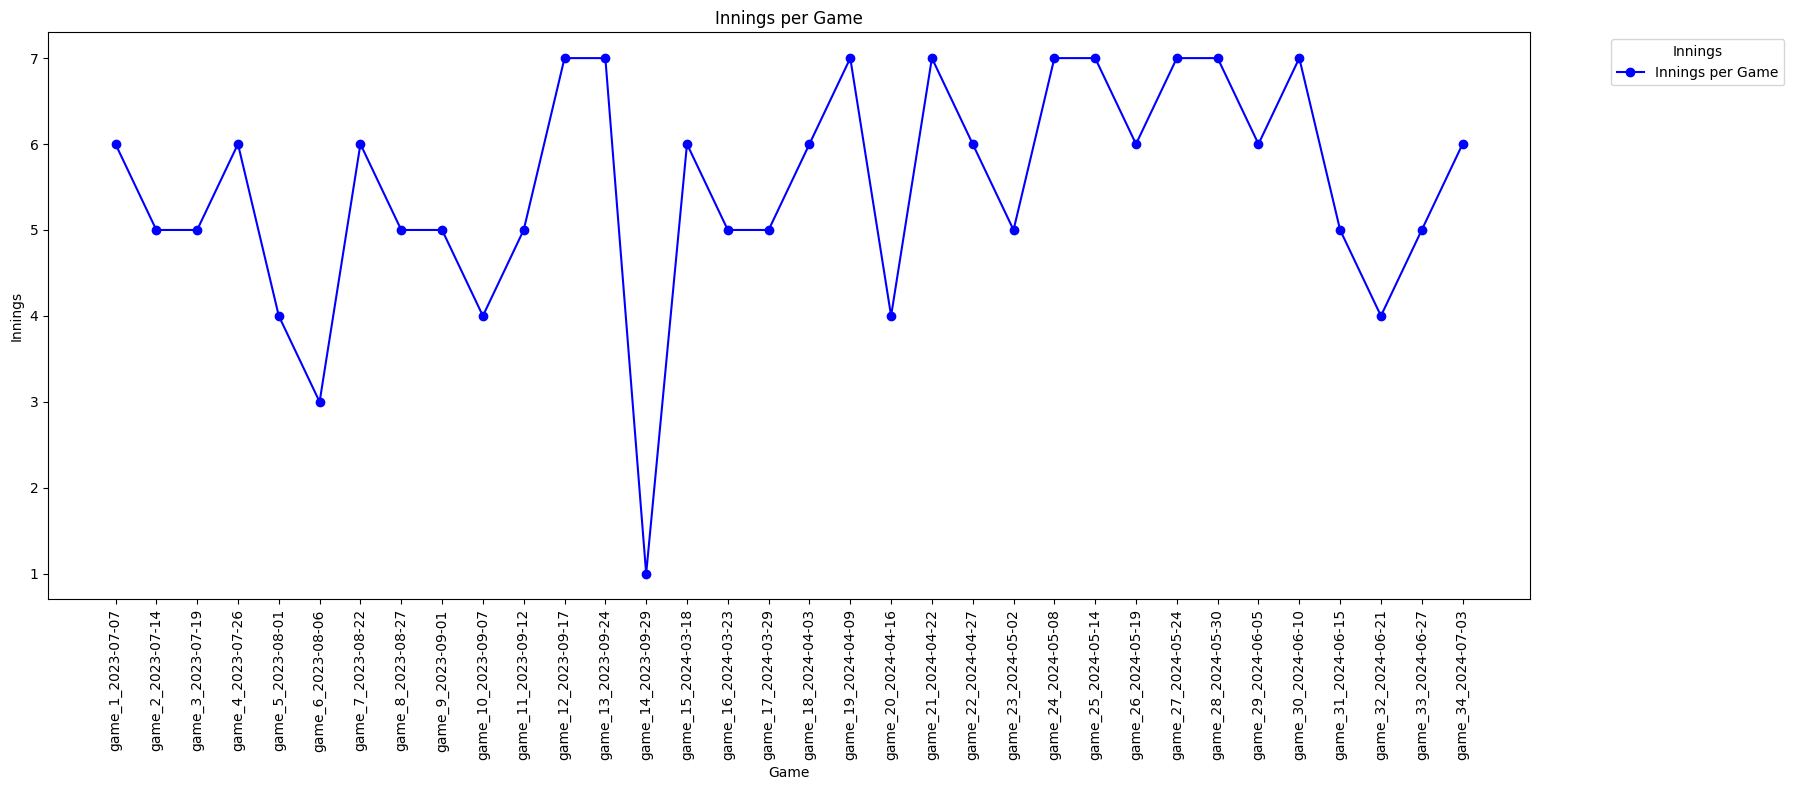

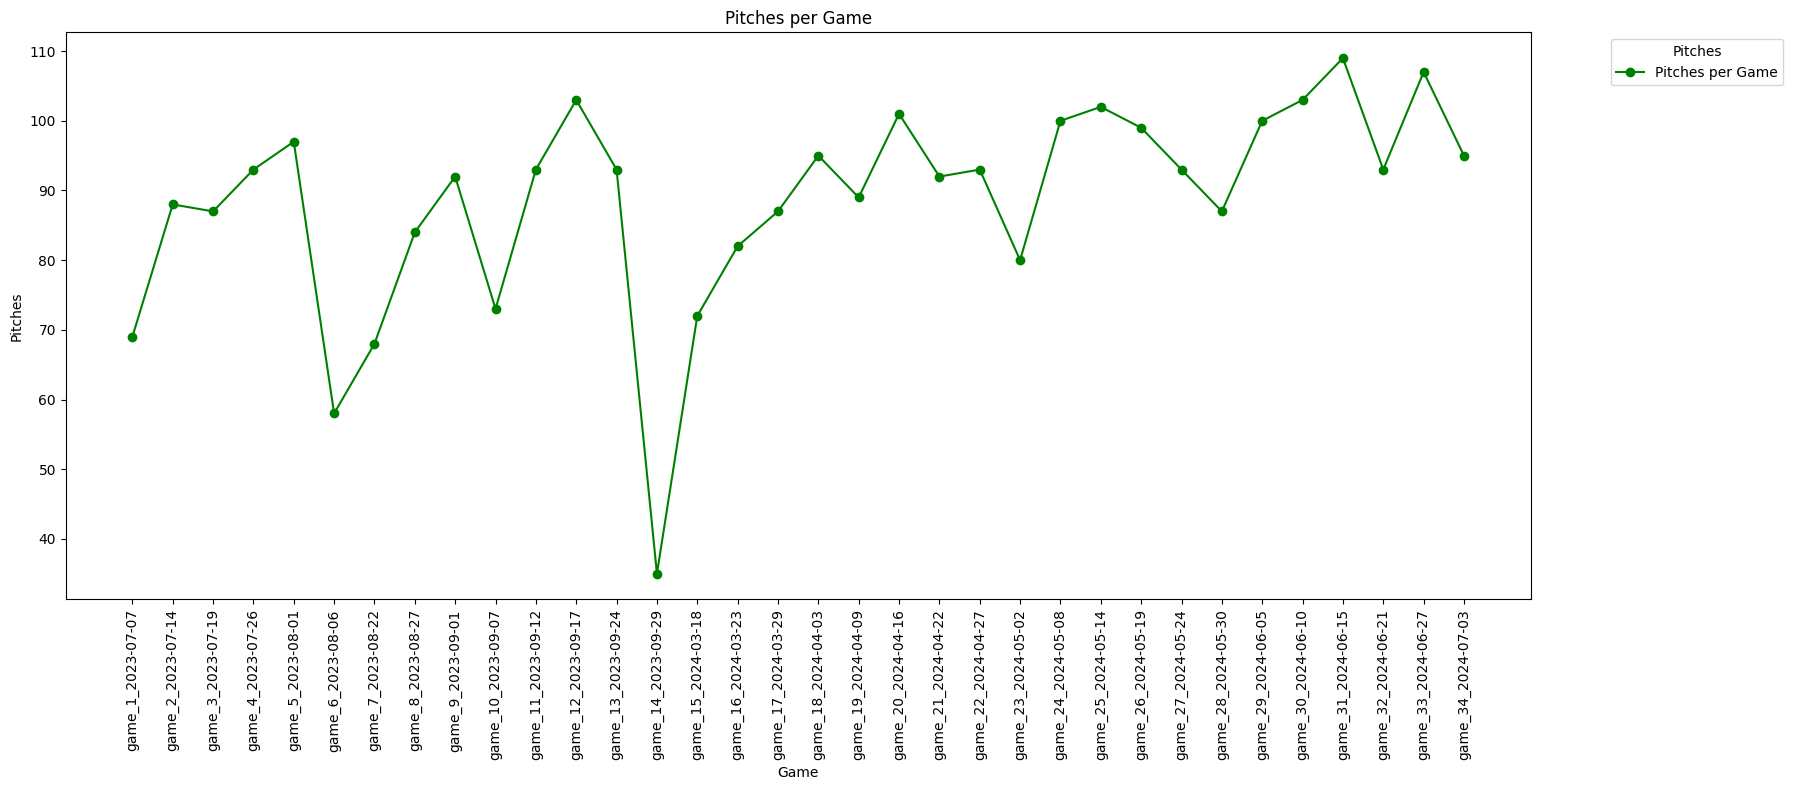

Нет доступных данных для Event Counts.


<Figure size 1800x800 with 0 Axes>

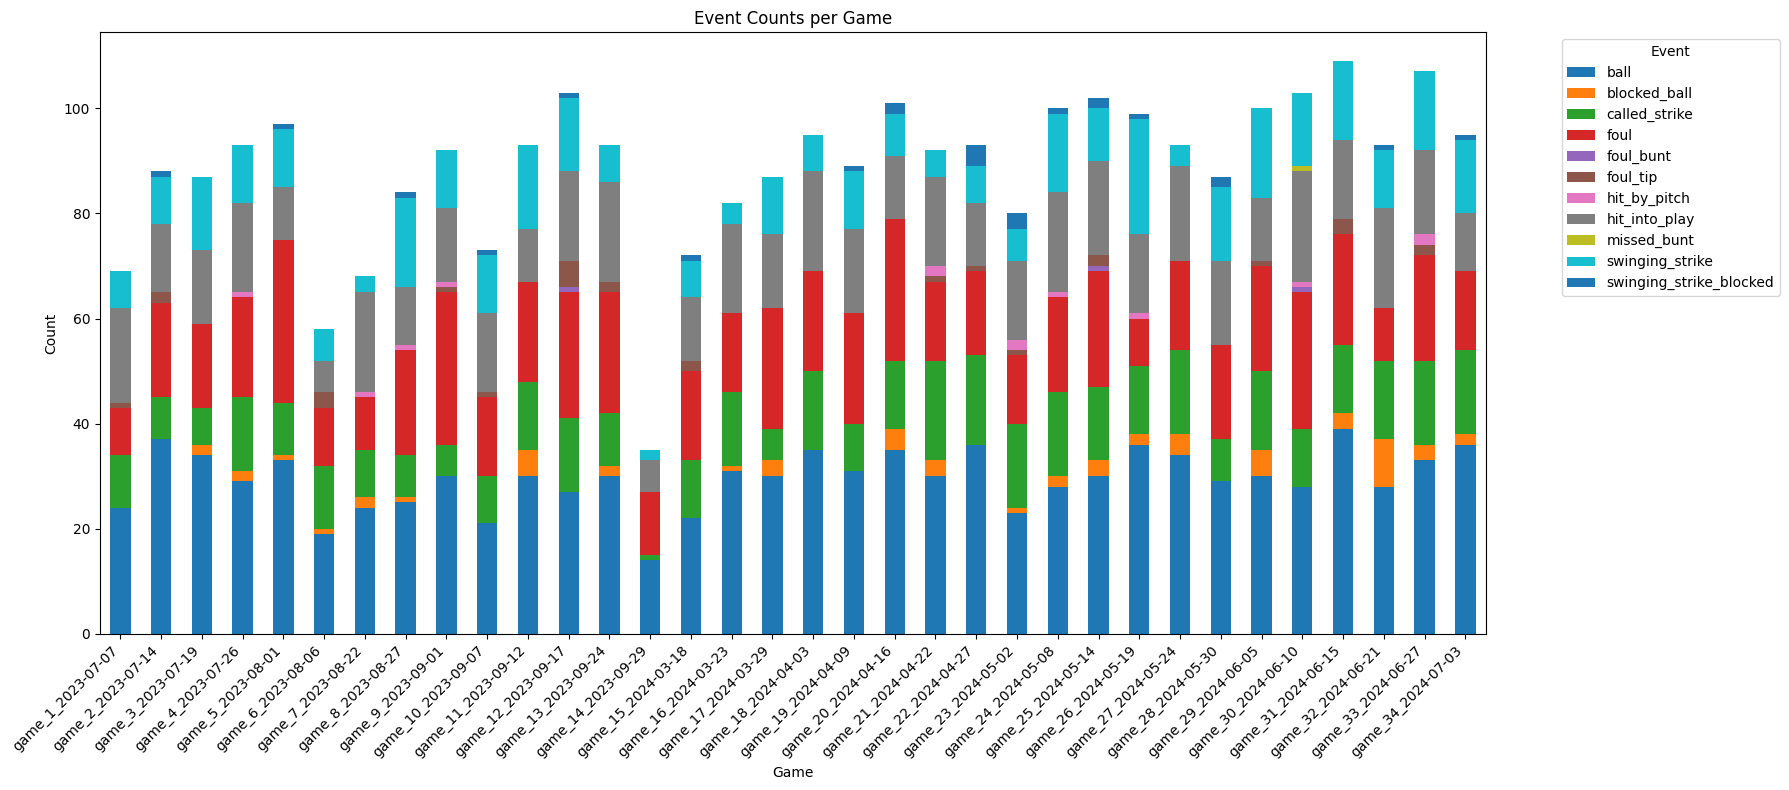

<Figure size 1800x800 with 0 Axes>

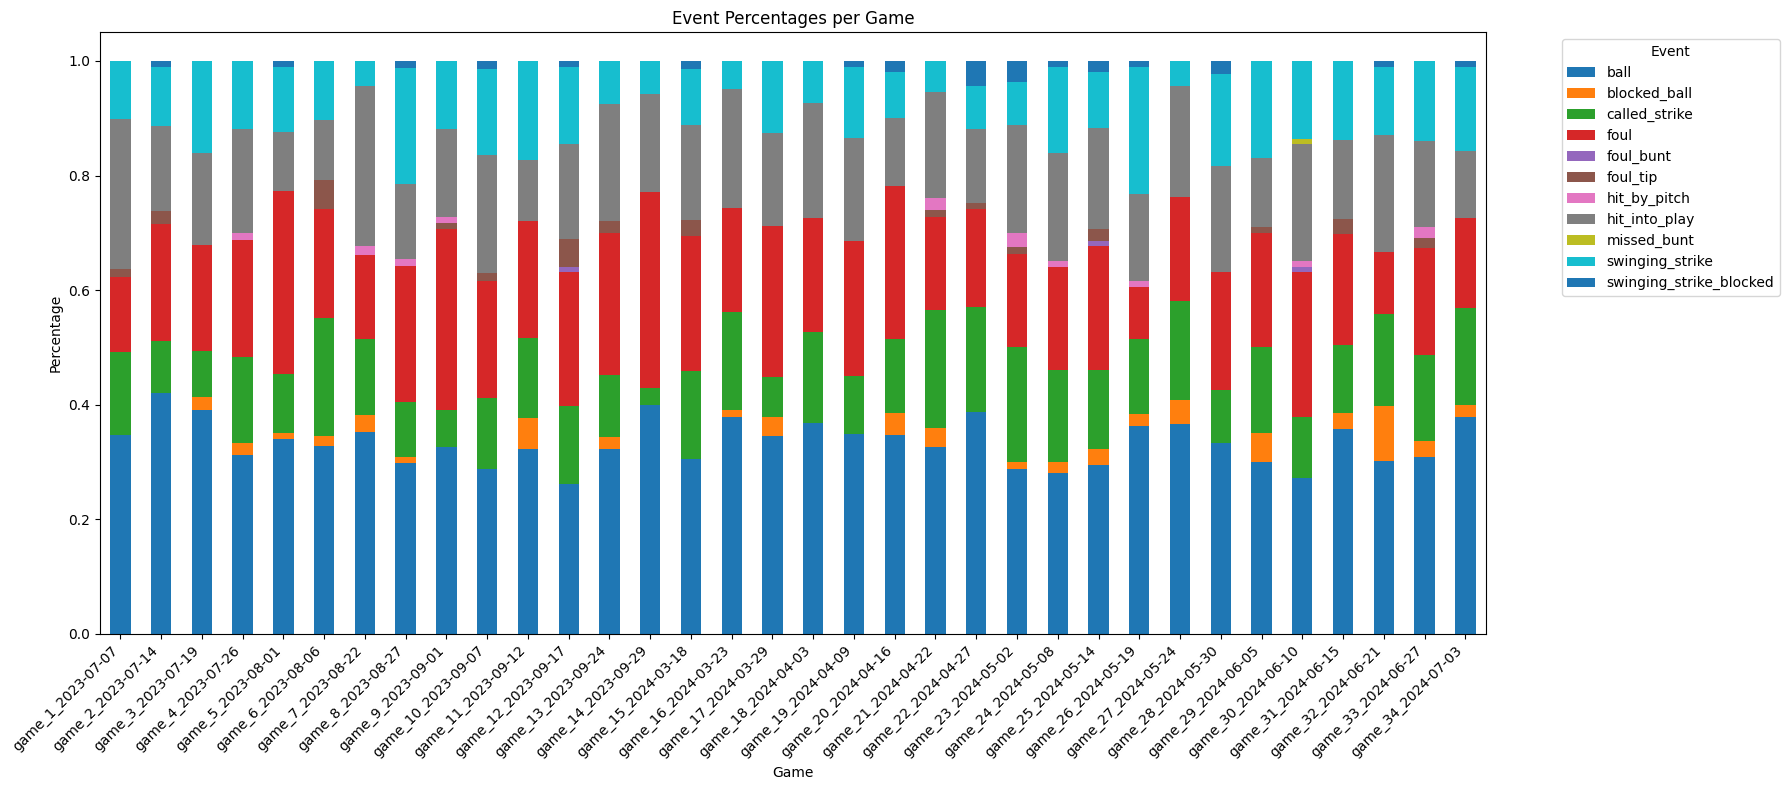

Нет доступных данных для Pitch Speeds.


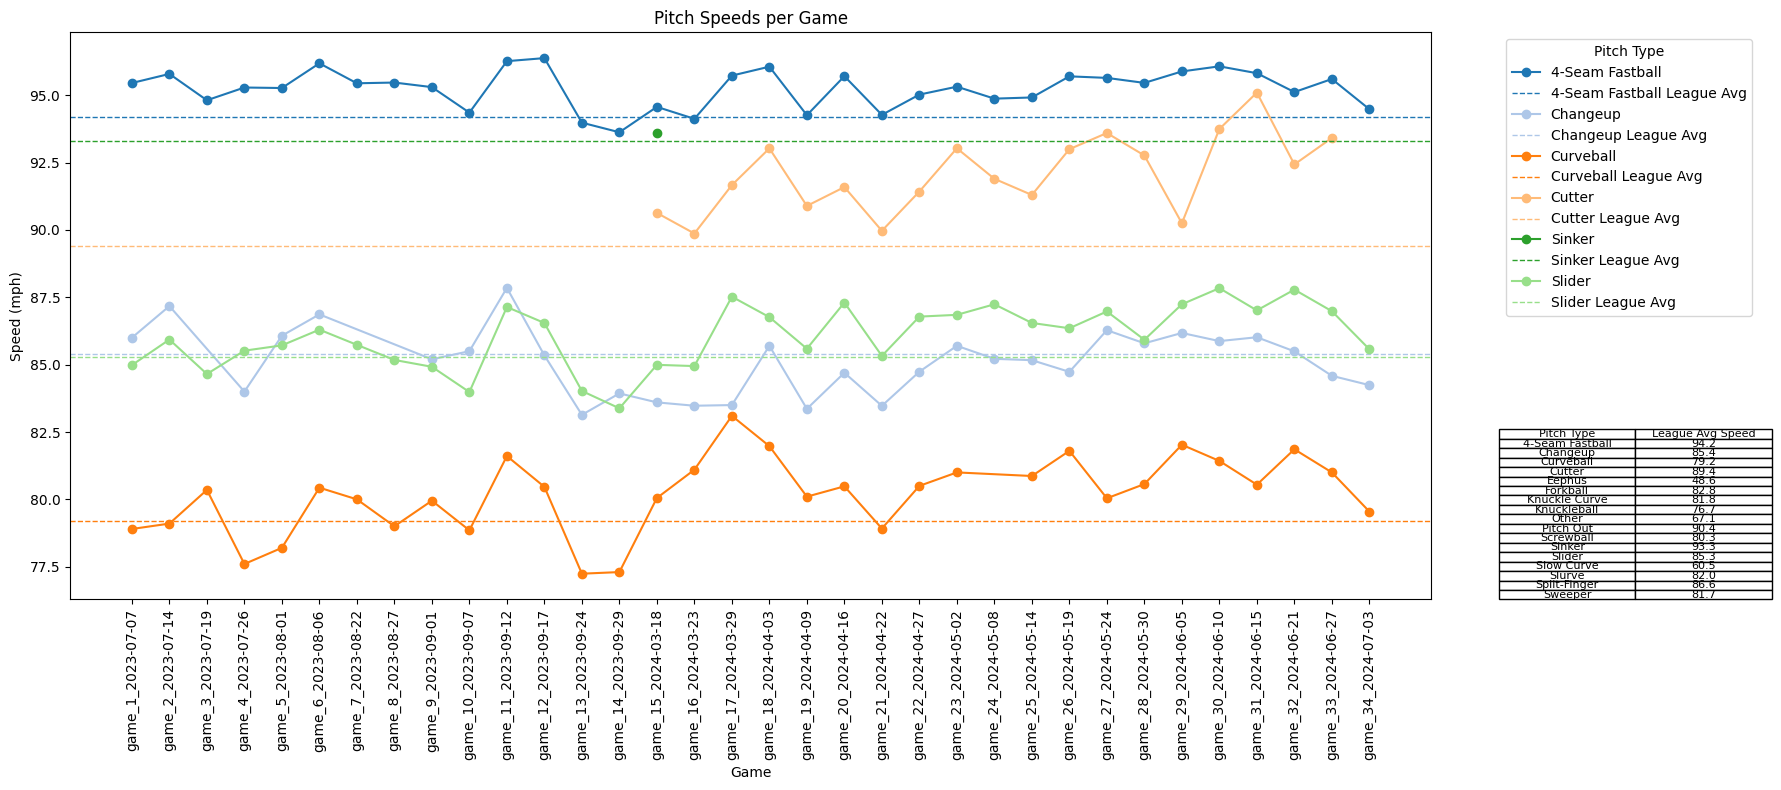


        Описание 'estimated_woba_using_speedangle':
        Это метрика, основанная на скорости и угле выхода мяча после удара. Она оценивает ожидаемое значение 
        среднего веса (wOBA) для каждого удара. Метрика учитывает качество контакта, что помогает лучше понять 
        результативность подач и качество ударов.
        
Нет доступных данных для Pitch Quality.


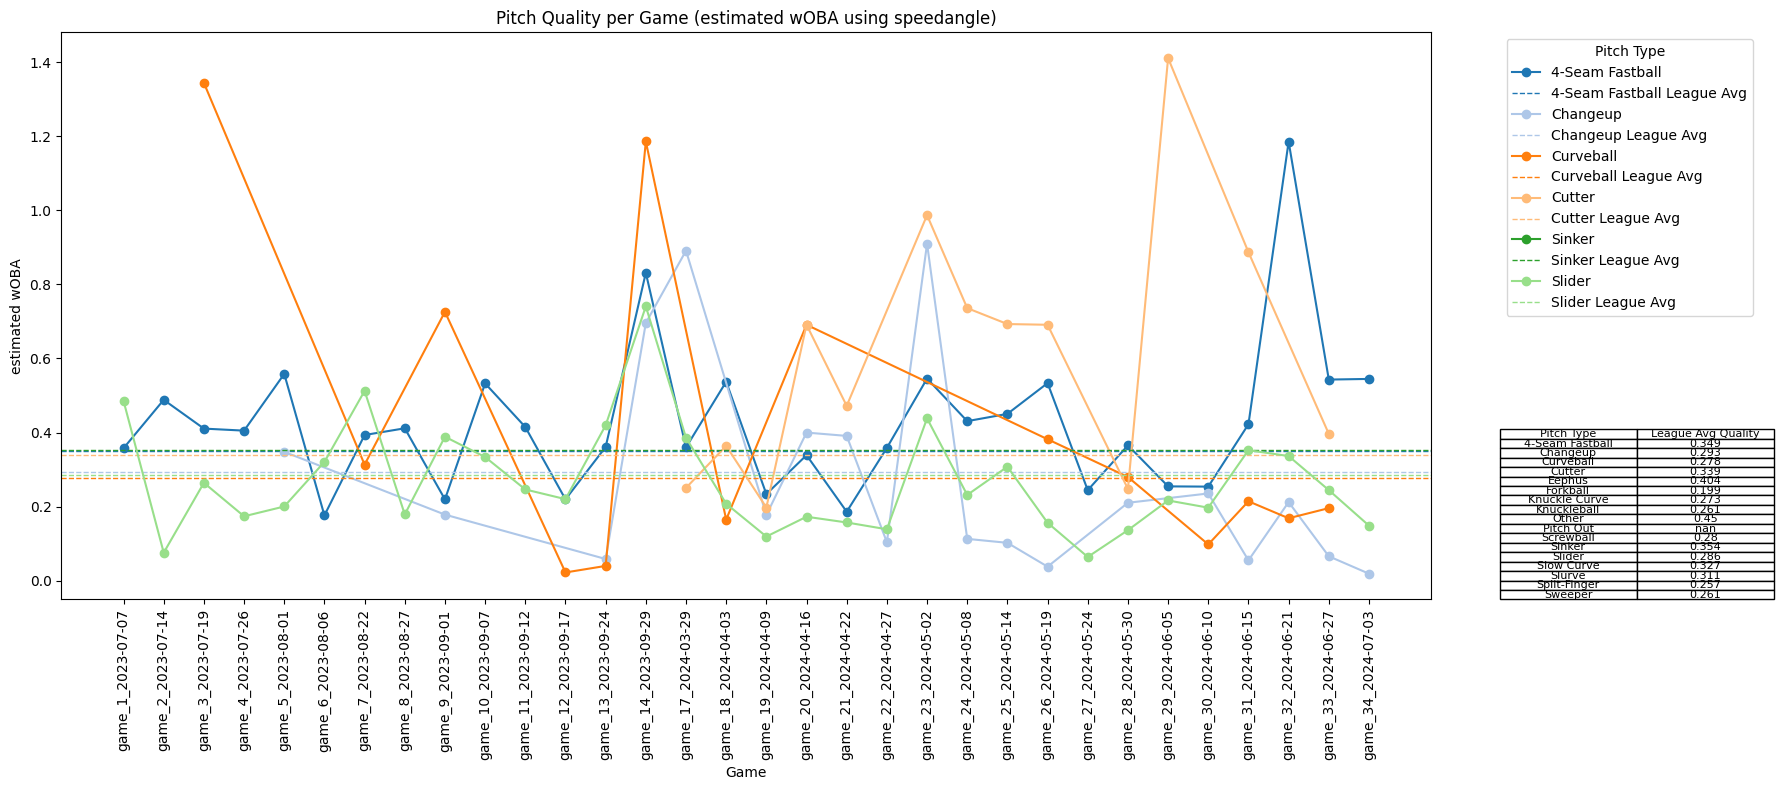

Нет доступных данных для Pitch Counts.


<Figure size 1800x800 with 0 Axes>

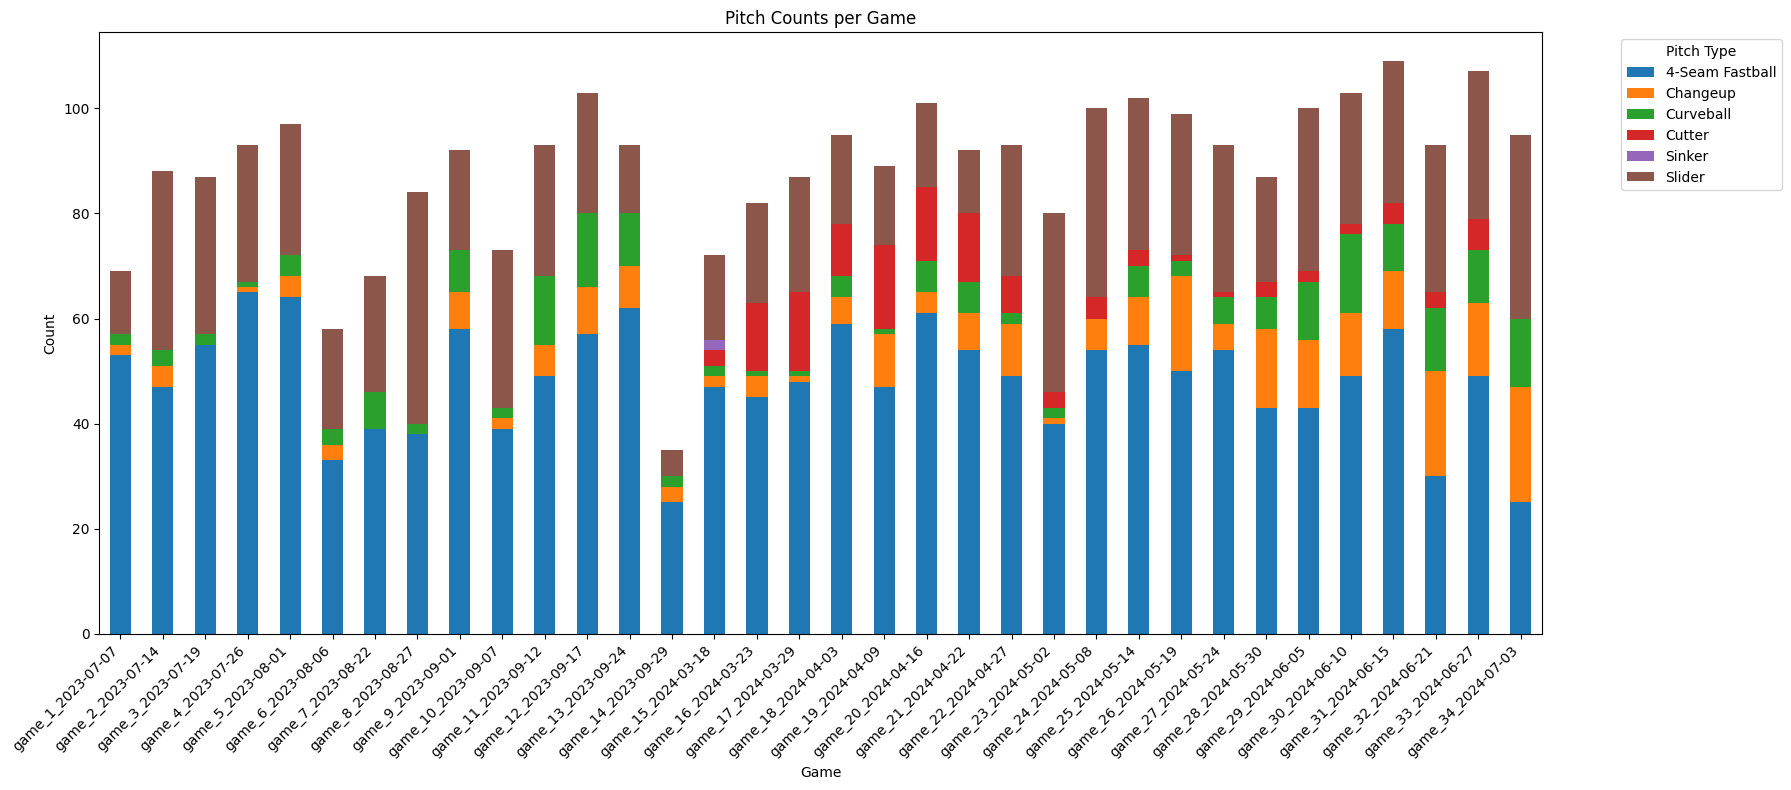

<Figure size 1800x800 with 0 Axes>

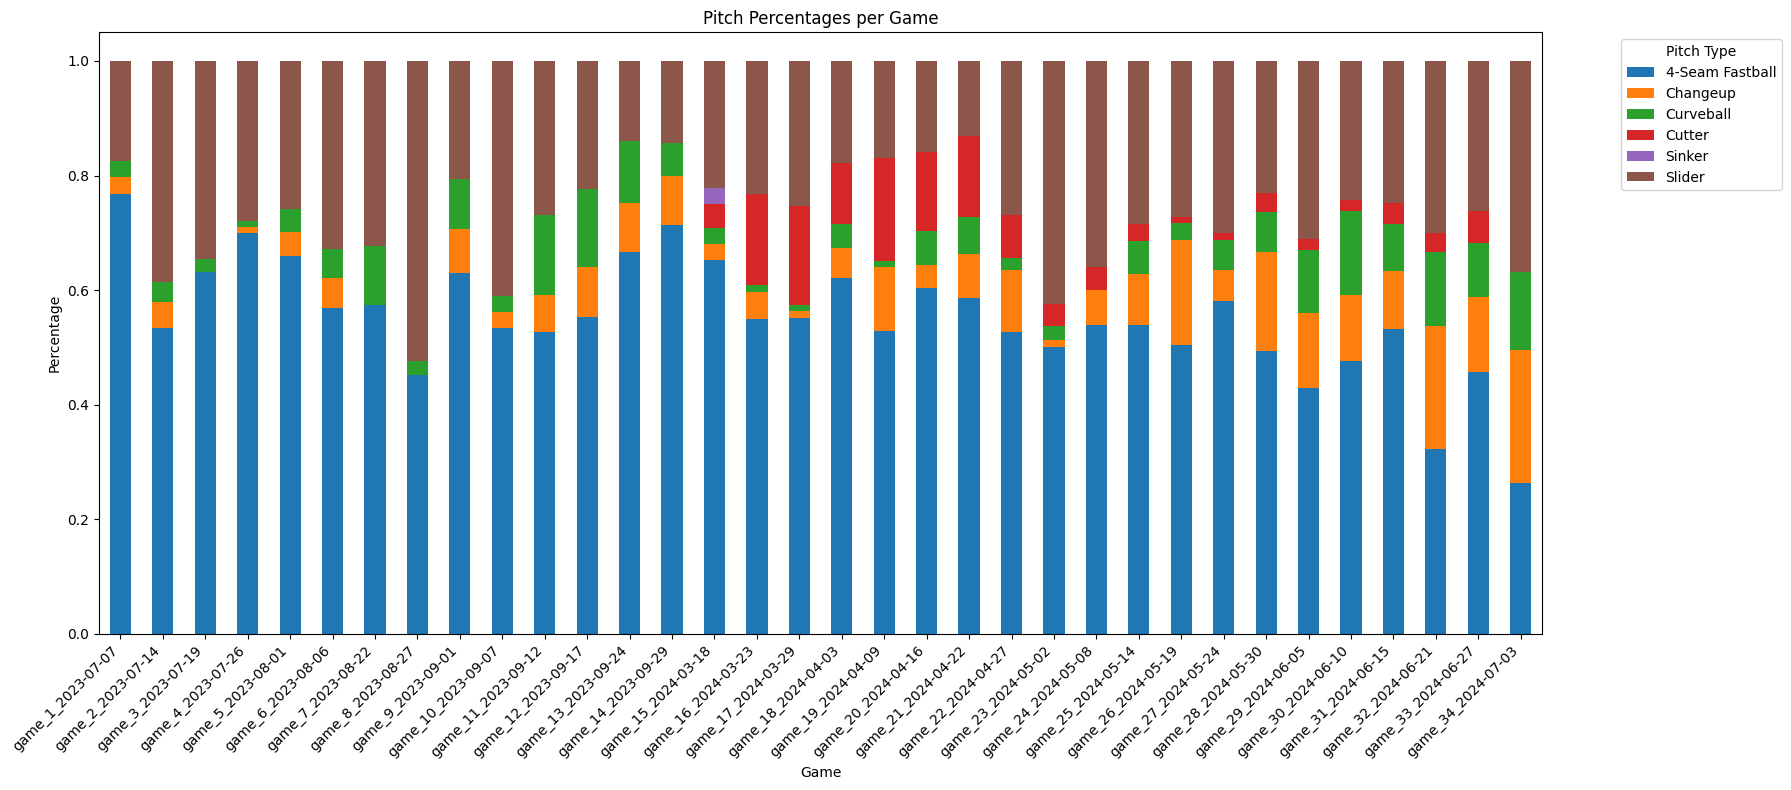

11      |      12
  -------------
  | 1 | 2 | 3 |
  -------------
--| 4 | 5 | 6 |--
  -------------
  | 7 | 8 | 9 |
  -------------
13      |      14

Нет доступных данных для Zone Counts.


<Figure size 1800x800 with 0 Axes>

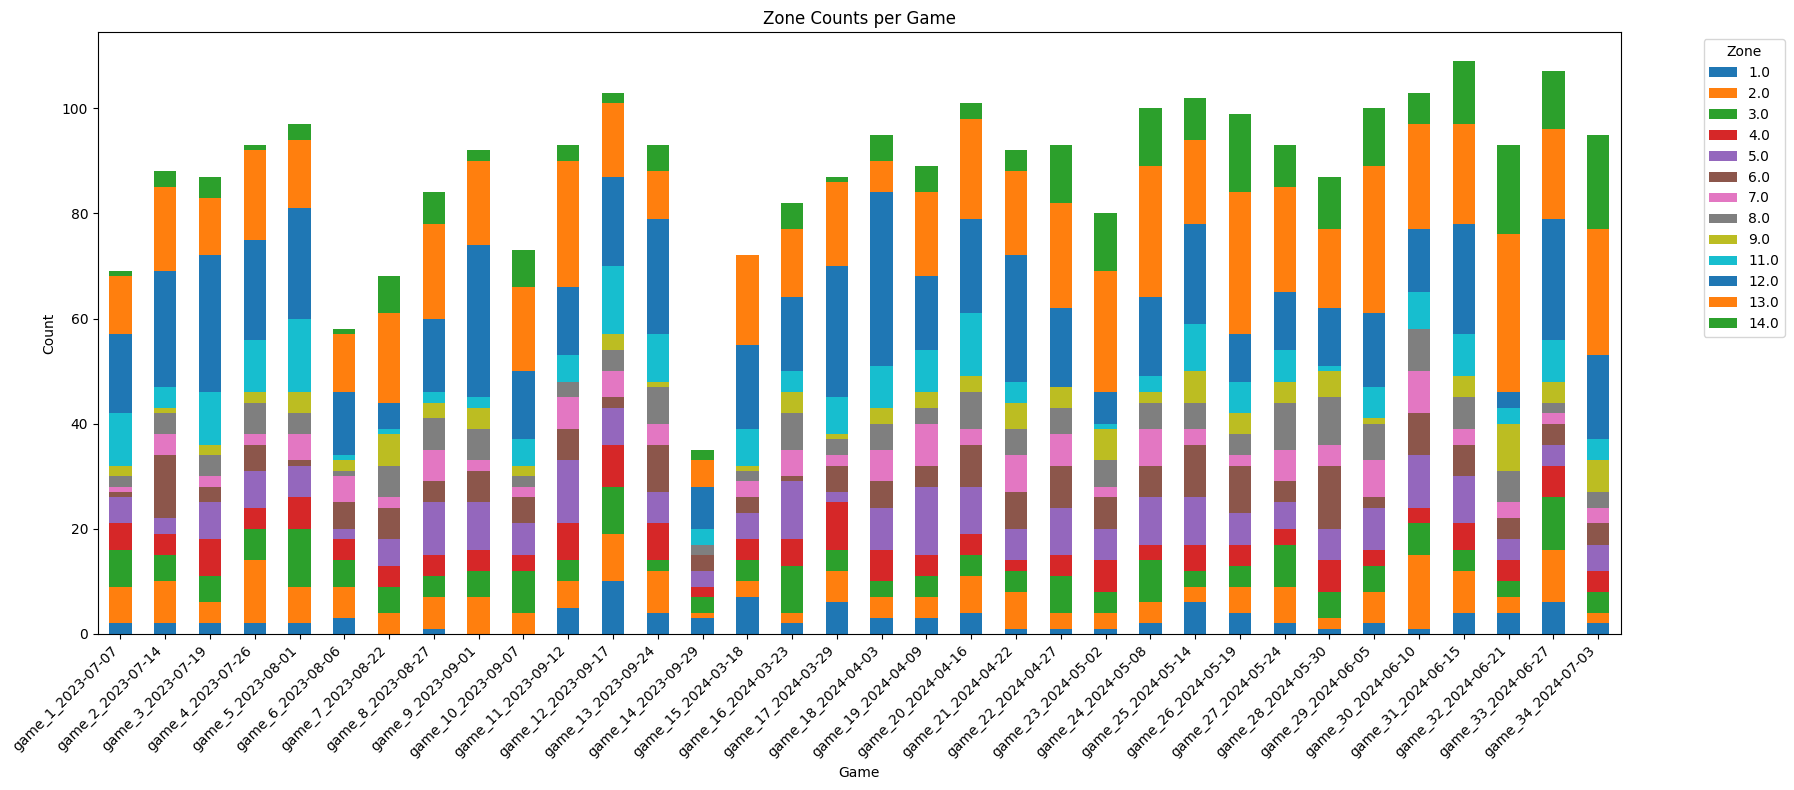

<Figure size 1800x800 with 0 Axes>

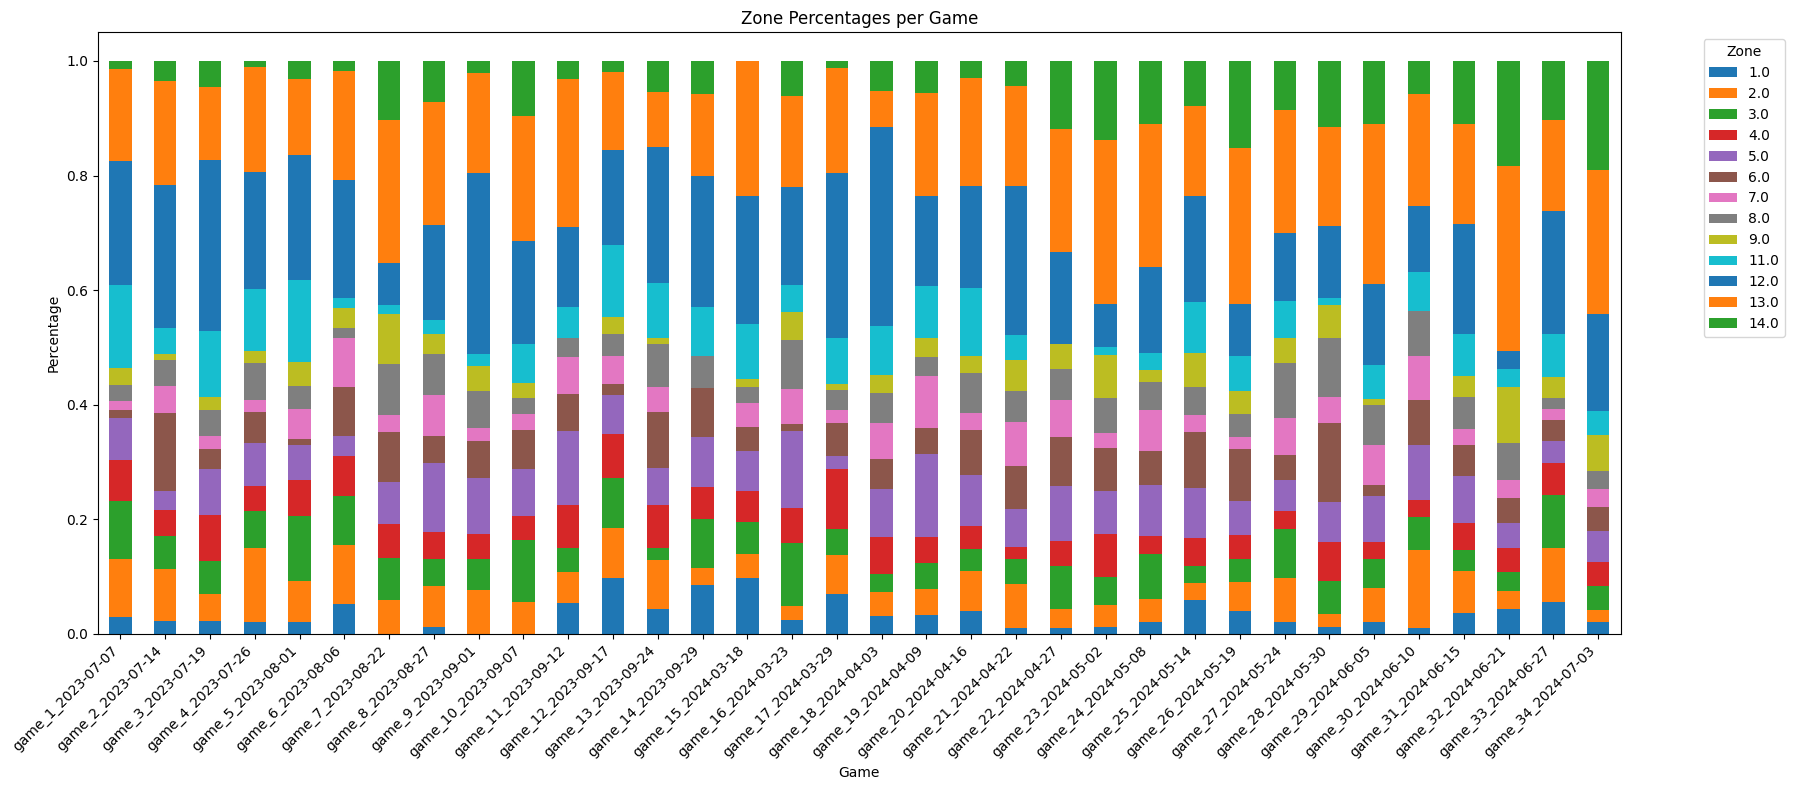

In [27]:
def get_all_seasons_games(data_2024, data_2023, pitcher_id):
    data_2024['game_date'] = pd.to_datetime(data_2024['game_date'])
    data_2023['game_date'] = pd.to_datetime(data_2023['game_date'])
    data = pd.concat([data_2024, data_2023])
    
    player_info = playerid_reverse_lookup([pitcher_id], key_type='mlbam')
    if player_info.empty:
        print("Питчер не найден")
        return None
    
    pitcher_name = f"{player_info.iloc[0]['name_first']} {player_info.iloc[0]['name_last']}"
    print(f"Питчер: {pitcher_name}")

    
    pitcher_stats = calculate_pitcher_stats(pitcher_id, data_2023, data_2024)
    print_pitcher_stats = format_pitcher_stats(pitcher_stats)
    print(print_pitcher_stats)
    
    required_columns = ['pitcher', 'game_date', 'home_team', 'away_team', 'inning', 'pitch_name', 'release_speed', 'events', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'description', 'zone']
    for column in required_columns:
        if column not in data.columns:
            print(f"Столбец '{column}' отсутствует в данных.")
            return None
    
    pitcher_data = data[data['pitcher'] == pitcher_id]
    pitcher_data_sorted = pitcher_data.sort_values(by='game_date', ascending=True)
    all_game_dates = pitcher_data_sorted['game_date'].unique()
    all_games = pitcher_data_sorted[pitcher_data_sorted['game_date'].isin(all_game_dates)]
    
    if 'team' in all_games.columns:
        team = all_games.iloc[0]['team']
    else:
        team = None
    
    all_games['game_num'] = all_games.groupby('game_date').ngroup() + 1
    all_games['game_name'] = 'game_' + all_games['game_num'].astype(str) + '_' + all_games['game_date'].dt.strftime('%Y-%m-%d')
    
    for game_date in all_games['game_date'].unique():
        game_data = all_games[all_games['game_date'] == game_date]
        if team:
            opponents = game_data.apply(lambda row: f"{team} - {row['away_team']}" if row['home_team'] == team else f"{team} - {row['home_team']}", axis=1).unique()
        else:
            opponents = game_data.apply(lambda row: f"{row['home_team']} - {row['away_team']}", axis=1).unique()
        
        game_num = game_data['game_num'].iloc[0]
        max_inning = game_data['inning'].max()
        
        print(f"Дата: {game_date.date()}, Игра: {', '.join(opponents)}, игре присвоен номер {game_num}, всего иннингов {max_inning}")
    
    game_event_counts = pd.pivot_table(all_games, index='game_name', columns='description', values='pitcher', aggfunc='count', fill_value=0)
    game_order = sorted(all_games['game_name'].unique(), key=lambda x: int(x.split('_')[1]))
    game_event_counts = game_event_counts.reindex(game_order)
    
    game_pitch_speeds = all_games.groupby(['game_name', 'pitch_name'])['release_speed'].mean().unstack(fill_value=0)
    game_pitch_speeds = game_pitch_speeds.reindex(game_order)
    
    game_pitch_quality = all_games.groupby(['game_name', 'pitch_name'])['estimated_woba_using_speedangle'].mean().unstack(fill_value=0)
    game_pitch_quality = game_pitch_quality.reindex(game_order)
    
    game_pitch_counts = pd.pivot_table(all_games, index='game_name', columns='pitch_name', values='pitcher', aggfunc='count', fill_value=0)
    game_pitch_counts = game_pitch_counts.reindex(game_order)
    
    game_zone_counts = pd.pivot_table(all_games, index='game_name', columns='zone', values='pitcher', aggfunc='count', fill_value=0)
    game_zone_counts = game_zone_counts.reindex(game_order)
    
    # Количество иннингов за игру
    innings_per_game = all_games.groupby('game_name')['inning'].max().reindex(game_order)
    
    # Количество подач за игру
    pitches_per_game = all_games.groupby('game_name')['pitcher'].count().reindex(game_order)
    
    # Вычисляем средние значения по всей лиге для типов подачи
    league_avg_speeds = data.groupby('pitch_name')['release_speed'].mean()
    league_avg_quality = data.groupby('pitch_name')['estimated_woba_using_speedangle'].mean()
    
    tables = {
        'event_counts': game_event_counts,
        'pitch_speeds': game_pitch_speeds,
        'pitch_quality': game_pitch_quality,
        'pitch_counts': game_pitch_counts,
        'zone_counts': game_zone_counts,
        'league_avg_speeds': league_avg_speeds,
        'league_avg_quality': league_avg_quality,
        'innings_per_game': innings_per_game,
        'pitches_per_game': pitches_per_game
    }
    
    return tables, pitcher_data, pitcher_name

def plot_tables(tables, pitcher_data, pitcher_name):
    def print_stats(table, table_name, data, numerical_columns):
        available_columns = [col for col in numerical_columns if col in data.columns]
        if not available_columns:
            print(f"Нет доступных данных для {table_name}.")
            return
        
        mean_values = data[available_columns].mean()
        percentile_90_values = data[available_columns].quantile(0.9)
        
        print(f"Средние значения для {table_name}:")
        for event, value in mean_values.items():
            print(f"{event}: {value:.2f}")
        print(f"\n90-й процентиль для {table_name}:")
        for event, value in percentile_90_values.items():
            print(f"{event}: {value:.2f}")
        
        print(f"\nСредние значения питчера для {table_name}:")
        for col in available_columns:
            if col in pitcher_data.columns:
                pitcher_mean = pitcher_data[col].mean()
                print(f"{col}: {pitcher_mean:.2f}")
            else:
                print(f"Данные для {col} отсутствуют в данных питчера.")
        
        print("\n")
    
    print(f"\nПитчер: {pitcher_name}\n")
    
    # Определяем расширенный набор цветов
    color_cycle = plt.cm.tab20(np.linspace(0, 1, 20))
    pitch_types = tables['pitch_speeds'].columns.tolist()
    colors = dict(zip(pitch_types, itertools.cycle(color_cycle)))

    if 'innings_per_game' in tables:
        plt.figure(figsize=(18, 8))
        plt.plot(tables['innings_per_game'].index, tables['innings_per_game'], marker='o', label='Innings per Game', color='blue')
        plt.title('Innings per Game')
        plt.xlabel('Game')
        plt.ylabel('Innings')
        plt.legend(title='Innings', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    if 'pitches_per_game' in tables:
        plt.figure(figsize=(18, 8))
        plt.plot(tables['pitches_per_game'].index, tables['pitches_per_game'], marker='o', label='Pitches per Game', color='green')
        plt.title('Pitches per Game')
        plt.xlabel('Game')
        plt.ylabel('Pitches')
        plt.legend(title='Pitches', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    if 'event_counts' in tables:
        numerical_columns = tables['event_counts'].select_dtypes(include=[np.number]).columns.tolist()
        print_stats(tables['event_counts'], 'Event Counts', pitcher_data, numerical_columns)
        
        plt.figure(figsize=(18, 8))
        ax = tables['event_counts'].plot(kind='bar', stacked=True, figsize=(18, 8))
        plt.title('Event Counts per Game')
        plt.xlabel('Game')
        plt.ylabel('Count')
        plt.legend(title='Event', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        event_percentage = tables['event_counts'].div(tables['event_counts'].sum(axis=1), axis=0)
        plt.figure(figsize=(18, 8))
        ax = event_percentage.plot(kind='bar', stacked=True, figsize=(18, 8))
        plt.title('Event Percentages per Game')
        plt.xlabel('Game')
        plt.ylabel('Percentage')
        plt.legend(title='Event', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    if 'pitch_speeds' in tables:
        numerical_columns = tables['pitch_speeds'].select_dtypes(include=[np.number]).columns.tolist()
        print_stats(tables['pitch_speeds'], 'Pitch Speeds', pitcher_data, numerical_columns)
        
        plt.figure(figsize=(18, 8))
        for pitch in tables['pitch_speeds'].columns:
            pitch_data = tables['pitch_speeds'][tables['pitch_speeds'][pitch] > 0]
            color = colors.get(pitch, 'black')
            plt.plot(pitch_data.index, pitch_data[pitch], marker='o', label=pitch, color=color)
            league_avg = round(tables['league_avg_speeds'][pitch], 1)  # округление до 1 цифры после запятой
            plt.axhline(y=league_avg, color=color, linestyle='--', linewidth=1, label=f'{pitch} League Avg')
        
        # Создаем таблицу с названиями типов подач и средними значениями по лиге
        league_avg_speeds_rounded = tables['league_avg_speeds'].apply(lambda x: round(x, 1))  # округление до 1 цифры после запятой
        table_data = league_avg_speeds_rounded.reset_index().values
        table = plt.table(cellText=table_data,
                          colLabels=['Pitch Type', 'League Avg Speed'],
                          cellLoc='center', loc='upper right', bbox=[1.05, 0, 0.2, 0.3])  # Позиция таблицы ниже легенды
        
        plt.title('Pitch Speeds per Game')
        plt.xlabel('Game')
        plt.ylabel('Speed (mph)')
        plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    if 'pitch_quality' in tables:
        description = """
        Описание 'estimated_woba_using_speedangle':
        Это метрика, основанная на скорости и угле выхода мяча после удара. Она оценивает ожидаемое значение 
        среднего веса (wOBA) для каждого удара. Метрика учитывает качество контакта, что помогает лучше понять 
        результативность подач и качество ударов.
        """
        print(description)
        
        numerical_columns = tables['pitch_quality'].select_dtypes(include=[np.number]).columns.tolist()
        print_stats(tables['pitch_quality'], 'Pitch Quality', pitcher_data, numerical_columns)
        
        plt.figure(figsize=(18, 8))
        for pitch in tables['pitch_quality'].columns:
            pitch_data = tables['pitch_quality'][tables['pitch_quality'][pitch] > 0]
            color = colors.get(pitch, 'black')
            plt.plot(pitch_data.index, pitch_data[pitch], marker='o', label=pitch, color=color)
            league_avg = round(tables['league_avg_quality'][pitch], 3)  # округление до 3 цифр после запятой
            plt.axhline(y=league_avg, color=color, linestyle='--', linewidth=1, label=f'{pitch} League Avg')
        
        # Создаем таблицу с названиями типов подач и средними значениями по лиге
        league_avg_quality_rounded = tables['league_avg_quality'].apply(lambda x: round(x, 3))  # округление до 3 цифр после запятой
        table_data = league_avg_quality_rounded.reset_index().values
        table = plt.table(cellText=table_data,
                          colLabels=['Pitch Type', 'League Avg Quality'],
                          cellLoc='center', loc='upper right', bbox=[1.05, 0, 0.2, 0.3])  # Позиция таблицы ниже легенды
        
        plt.title('Pitch Quality per Game (estimated wOBA using speedangle)')
        plt.xlabel('Game')
        plt.ylabel('estimated wOBA')
        plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    if 'pitch_counts' in tables:
        numerical_columns = tables['pitch_counts'].select_dtypes(include=[np.number]).columns.tolist()
        print_stats(tables['pitch_counts'], 'Pitch Counts', pitcher_data, numerical_columns)
        
        plt.figure(figsize=(18, 8))
        ax = tables['pitch_counts'].plot(kind='bar', stacked=True, figsize=(18, 8))
        plt.title('Pitch Counts per Game')
        plt.xlabel('Game')
        plt.ylabel('Count')
        plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        pitch_percentage = tables['pitch_counts'].div(tables['pitch_counts'].sum(axis=1), axis=0)
        plt.figure(figsize=(18, 8))
        ax = pitch_percentage.plot(kind='bar', stacked=True, figsize=(18, 8))
        plt.title('Pitch Percentages per Game')
        plt.xlabel('Game')
        plt.ylabel('Percentage')
        plt.legend(title='Pitch Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    if 'zone_counts' in tables:
        print("11      |      12")
        print("  -------------")
        print("  | 1 | 2 | 3 |")
        print("  -------------")
        print("--| 4 | 5 | 6 |--")
        print("  -------------")
        print("  | 7 | 8 | 9 |")
        print("  -------------")
        print("13      |      14\n")
        
        numerical_columns = tables['zone_counts'].select_dtypes(include=[np.number]).columns.tolist()
        print_stats(tables['zone_counts'], 'Zone Counts', pitcher_data, numerical_columns)
        
        plt.figure(figsize=(18, 8))
        ax = tables['zone_counts'].plot(kind='bar', stacked=True, figsize=(18, 8))
        plt.title('Zone Counts per Game')
        plt.xlabel('Game')
        plt.ylabel('Count')
        plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        zone_percentage = tables['zone_counts'].div(tables['zone_counts'].sum(axis=1), axis=0)
        plt.figure(figsize=(18, 8))
        ax = zone_percentage.plot(kind='bar', stacked=True, figsize=(18, 8))
        plt.title('Zone Percentages per Game')
        plt.xlabel('Game')
        plt.ylabel('Percentage')
        plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

tables, pitcher_data, pitcher_name = get_all_seasons_games(data_2024, data_2023, pitcher_id)
if tables:
    plot_tables(tables, pitcher_data, pitcher_name)

## Вместо вывода

Ниже идут сначала просто названия всех столбцов, которые есть.  
Ещё ниже я перевёл все столбцы с описанием того, что они означают.  
Как я говорил выше, есть, как минимум, 6,6 млн. данных с 01.01.2015 (возможно, стоит попробовать увеличить период, но и 6,6 млн данных очень много). Любые предложения, как можно использовать эти данные приветствуются

In [ ]:
data_2024.columns.tolist()

Вот перевод и краткое описание всех столбцов из данных Statcast:

pitch_type - тип подачи (например, fastball, curveball и т.д.)  
game_date - дата игры  
release_speed - скорость выпуска мяча (в милях в час)  
release_pos_x - позиция выпуска мяча по оси X  
release_pos_z - позиция выпуска мяча по оси Z  
player_name - имя игрока  
batter - идентификатор (ID) отбивающего игрока  
pitcher - идентификатор (ID) подающего игрока  
events - событие (например, strikeout, home run и т.д.)  
description - описание подачи  
spin_dir - направление вращения (0 non-null)  
spin_rate_deprecated - скорость вращения (0 non-null)  
break_angle_deprecated - угол отклонения (0 non-null)  
break_length_deprecated - длина отклонения (0 non-null)  
zone - зона подачи  
des - описание события  
game_type - тип игры (например, регулярный сезон, плей-офф и т.д.)  
stand - стойка отбивающего (левша/правша)  
p_throws - бросок подающего (левша/правша)  
home_team - домашняя команда  
away_team - гостевая команда  
type - тип подачи (удар или мяч)  
hit_location - место попадания удара  
bb_type - тип удара (например, ground ball, fly ball и т.д.)  
balls - количество мячей в текущем выходе на биту  
strikes - количество страйков в текущем выходе на биту  
game_year - год игры  
pfx_x - отклонение подачи по оси X  
pfx_z - отклонение подачи по оси Z  
plate_x - позиция мяча относительно пластины по оси X  
plate_z - позиция мяча относительно пластины по оси Z  
on_3b - идентификатор (ID) игрока на третьей базе  
on_2b - идентификатор (ID) игрока на второй базе  
on_1b - идентификатор (ID) игрока на первой базе  
outs_when_up - количество аутов при выходе на биту  
inning - номер иннинга  
inning_topbot - верх или низ иннинга  
hc_x - координата X точки удара по мячу  
hc_y - координата Y точки удара по мячу  
tfs_deprecated - время подачи (0 non-null)  
tfs_zulu_deprecated - время подачи в формате Zulu (0 non-null)  
fielder_2 - идентификатор (ID) кетчера  
umpire - идентификатор (ID) судьи (0 non-null)  
sv_id - идентификатор события (0 non-null)  
vx0 - начальная скорость мяча по оси X  
vy0 - начальная скорость мяча по оси Y  
vz0 - начальная скорость мяча по оси Z  
ax - ускорение мяча по оси X  
ay - ускорение мяча по оси Y  
az - ускорение мяча по оси Z  
sz_top - верхняя граница зоны страйка  
sz_bot - нижняя граница зоны страйка  
hit_distance_sc - расстояние удара по мячу (в футах)  
launch_speed - скорость запуска мяча  
launch_angle - угол запуска мяча  
effective_speed - эффективная скорость мяча  
release_spin_rate - скорость вращения мяча при выпуске  
release_extension - расстояние от горки подающего до точки выпуска мяча  
game_pk - уникальный идентификатор игры  
pitcher.1 - идентификатор (ID) подающего (дублируется)  
fielder_2.1 - идентификатор (ID) кетчера (дублируется)  
fielder_3 - идентификатор (ID) игрока первой базы  
fielder_4 - идентификатор (ID) игрока второй базы  
fielder_5 - идентификатор (ID) игрока третьей базы  
fielder_6 - идентификатор (ID) шортстопа  
fielder_7 - идентификатор (ID) левого аутфилдера  
fielder_8 - идентификатор (ID) центрального аутфилдера  
fielder_9 - идентификатор (ID) правого аутфилдера  
release_pos_y - позиция выпуска мяча по оси Y  
estimated_ba_using_speedangle - оценка среднего по скорости и углу запуска мяча  
estimated_woba_using_speedangle - оценка wOBA по скорости и углу запуска мяча  
woba_value - значение wOBA  
woba_denom - знаменатель для вычисления wOBA  
babip_value - значение BABIP (бита в игру)  
iso_value - значение ISO (изолированная мощность)  
launch_speed_angle - комбинация скорости и угла запуска мяча  
at_bat_number - номер выхода на биту  
pitch_number - номер подачи  
pitch_name - название подачи  
home_score - счет домашней команды  
away_score - счет гостевой команды  
bat_score - счет команды отбивающего  
fld_score - счет команды в поле  
post_away_score - окончательный счет гостевой команды  
post_home_score - окончательный счет домашней команды  
post_bat_score - окончательный счет команды отбивающего  
post_fld_score - окончательный счет команды в поле  
if_fielding_alignment - расположение игроков на внутреннем поле  
of_fielding_alignment - расположение игроков на внешнем поле  
spin_axis - ось вращения мяча (не используется)  
delta_home_win_exp - изменение вероятности победы домашней команды  
delta_run_exp - изменение ожидаемого количества пробежек  
bat_speed - скорость биты  
swing_length - длина размаха  